In [6]:
#复习日
#复现前15日所学内容，尽量并找到与控制工程相关的数据集，进行分析（最终不知道怎么找，目前没找到，就找了了一个非常简单的数据集）
#导入包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import shap
import warnings  # 用于处理警告信息
# 忽略所有警告信息，避免影响程序运行时的输出
warnings.filterwarnings("ignore")

# 设置中文字体（解决中文显示问题）
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统常用黑体字体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
#导入数据
data = pd.read_csv('ssd_failure_tag.csv')
data

,model,failure_time,failure,app,r_5,n_5,r_183,n_183,r_184,n_184,...,n_9,r_12,n_12,r_174,n_174,n_175,disk_id,node_id,rack_id,machine_room_id
0,A2,2018-01-02 19:15:32,1,RM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,33722,66688,11488,455
1,A2,2018-01-02 22:45:16,1,RM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,58337,114833,9859,455
2,A3,2018-01-03 03:29:27,1,RM,0.0,98.0,NaN,NaN,0.0,100.0,...,100.0,33.0,100.0,31.0,100.0,100.0,39876,217964,17596,92
3,C1,2018-01-03 05:03:03,1,NAS,0.0,100.0,0.0,100.0,0.0,100.0,...,100.0,19.0,100.0,17.0,100.0,NaN,199348,237451,22765,137
4,A2,2018-01-03 12:44:32,1,RM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,74564,146055,2321,455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18382,A2,2019-12-29 12:22:07,1,none,0.0,100.0,0.0,100.0,0.0,100.0,...,100.0,19.0,100.0,17.0,100.0,100.0,50890,100526,23122,143
18383,A4,2019-12-30 16:16:04,1,none,0.0,100.0,0.0,100.0,0.0,100.0,...,100.0,36.0,100.0,32.0,100.0,100.0,17665,106340,10724,159
18384,A1,2019-12-31 04:48:37,1,none,0.0,100.0,0.0,100.0,0.0,100.0,...,100.0,36.0,100.0,33.0,100.0,100.0,256933,216983,16184,408
18385,A1,2019-12-31 05:08:08,1,none,0.0,100.0,0.0,100.0,0.0,100.0,...,100.0,89.0,100.0,87.0,100.0,100.0,164724,139117,5836,632


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18387 entries, 0 to 18386
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   model            18387 non-null  object 
 1   failure_time     18387 non-null  object 
 2   failure          18387 non-null  int64  
 3   app              18387 non-null  object 
 4   r_5              18375 non-null  float64
 5   n_5              18375 non-null  float64
 6   r_183            16781 non-null  float64
 7   n_183            16781 non-null  float64
 8   r_184            18150 non-null  float64
 9   n_184            18150 non-null  float64
 10  r_187            18150 non-null  float64
 11  n_187            18150 non-null  float64
 12  r_195            15805 non-null  float64
 13  n_195            15805 non-null  float64
 14  r_197            17763 non-null  float64
 15  n_197            17763 non-null  float64
 16  r_199            18151 non-null  float64
 17  n_199       

In [8]:
#离散变量
discrete_features = data.select_dtypes(include=['object']).columns
discrete_features

Index(['model', 'failure_time', 'app'], dtype='object')

In [9]:
#连续变量
continuous_features = data.select_dtypes(include=['int64', 'float64']).columns
continuous_features

Index(['failure', 'r_5', 'n_5', 'r_183', 'n_183', 'r_184', 'n_184', 'r_187',
       'n_187', 'r_195', 'n_195', 'r_197', 'n_197', 'r_199', 'n_199',
       'r_program', 'n_program', 'r_erase', 'n_erase', 'n_blocks', 'n_wearout',
       'r_241', 'n_241', 'r_242', 'n_242', 'r_9', 'n_9', 'r_12', 'n_12',
       'r_174', 'n_174', 'n_175', 'disk_id', 'node_id', 'rack_id',
       'machine_room_id'],
      dtype='object')

In [10]:
# 使用中位数补全数值型特征的缺失值
for col in continuous_features:
    data[col] = data[col].fillna(data[col].median())

# 使用众数补全离散型特征的缺失值
for col in discrete_features:
    data[col] = data[col].fillna(data[col].mode()[0])

# 检查是否还有缺失值
data.isnull().sum()

model              0
failure_time       0
failure            0
app                0
r_5                0
n_5                0
r_183              0
n_183              0
r_184              0
n_184              0
r_187              0
n_187              0
r_195              0
n_195              0
r_197              0
n_197              0
r_199              0
n_199              0
r_program          0
n_program          0
r_erase            0
n_erase            0
n_blocks           0
n_wearout          0
r_241              0
n_241              0
r_242              0
n_242              0
r_9                0
n_9                0
r_12               0
n_12               0
r_174              0
n_174              0
n_175              0
disk_id            0
node_id            0
rack_id            0
machine_room_id    0
dtype: int64

In [11]:
for feature in discrete_features:
    print(f"\n{feature}的唯一值：")
    print(data[feature].value_counts())


model的唯一值：
model
C1    10510
B3     1807
A3     1370
C2     1131
A2      883
A1      747
B2      604
A4      461
B1      388
A5      260
A6      226
Name: count, dtype: int64

failure_time的唯一值：
failure_time
2019-01-17 03:24:36    13
2019-01-17 03:13:38    13
2019-06-16 05:31:59    12
2019-01-17 03:23:52    11
2018-08-11 03:14:31    11
                       ..
2018-01-06 08:40:48     1
2018-01-07 03:23:09     1
2018-01-07 09:37:30     1
2018-01-07 21:06:48     1
2019-12-31 16:16:05     1
Name: count, Length: 17649, dtype: int64

app的唯一值：
app
WSM     8916
none    3552
RM      3016
DAE     1214
NAS      541
WPS      529
WS       232
DB       203
SS       184
Name: count, dtype: int64


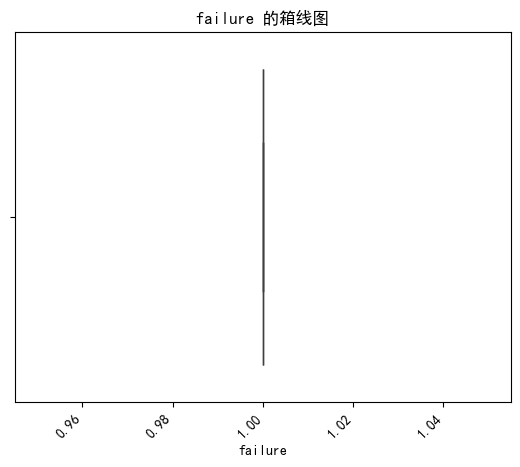

In [12]:

sns.boxplot(x=data['failure'])
plt.title('failure 的箱线图')
plt.xticks(rotation=45, ha='right')
plt.xlabel('failure')
plt.show()

In [13]:
"""
此图反映的问题
数据集中于一点：图中数据几乎集中在横轴 1.00 这个位置，说明大部分 failure 相关数据取值高度一致，可能是二分类变量中某一类占绝对主导（比如大部分样本设备未故障 ）。
无明显箱体和须：没有呈现出常规箱体和须的形态，而是近似一条竖线，进一步表明数据离散程度极低，取值变化极小。
可能的问题
数据错误：有可能数据记录有误，比如数据录入时大量重复录入同一值。
样本偏差：样本选取存在偏差，只涵盖了某一种情况的样本，缺失其他情况的数据。
变量特性：如果 failure 确实是二分类变量（如故障 = 1，无故障 = 0 ），可能是样本中故障情况极少（或无故障情况极少 ），导致数据集中在某一类取值上
"""

'\n此图反映的问题\n数据集中于一点：图中数据几乎集中在横轴 1.00 这个位置，说明大部分 failure 相关数据取值高度一致，可能是二分类变量中某一类占绝对主导（比如大部分样本设备未故障 ）。\n无明显箱体和须：没有呈现出常规箱体和须的形态，而是近似一条竖线，进一步表明数据离散程度极低，取值变化极小。\n可能的问题\n数据错误：有可能数据记录有误，比如数据录入时大量重复录入同一值。\n样本偏差：样本选取存在偏差，只涵盖了某一种情况的样本，缺失其他情况的数据。\n变量特性：如果 failure 确实是二分类变量（如故障 = 1，无故障 = 0 ），可能是样本中故障情况极少（或无故障情况极少 ），导致数据集中在某一类取值上\n'

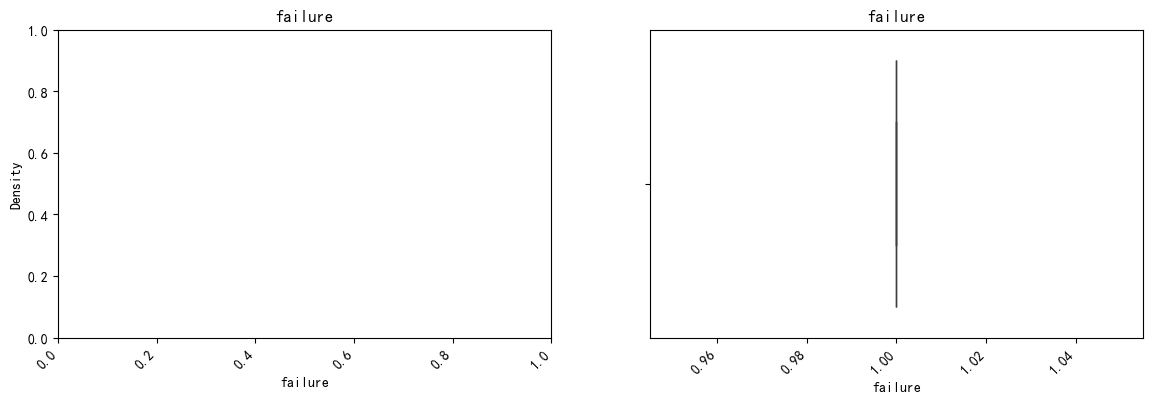

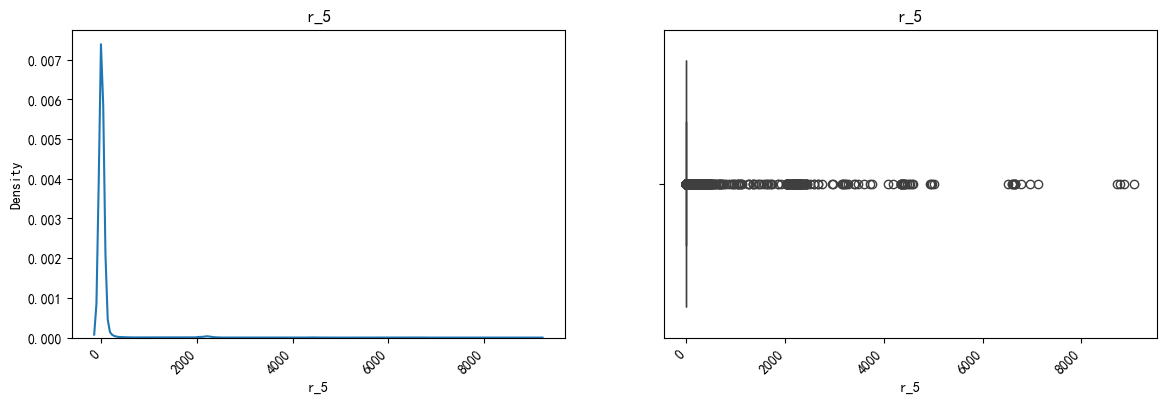

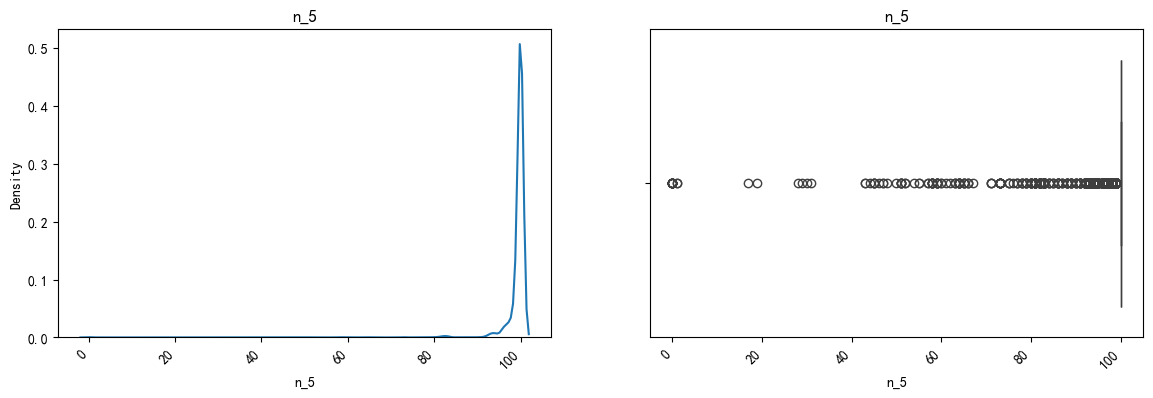

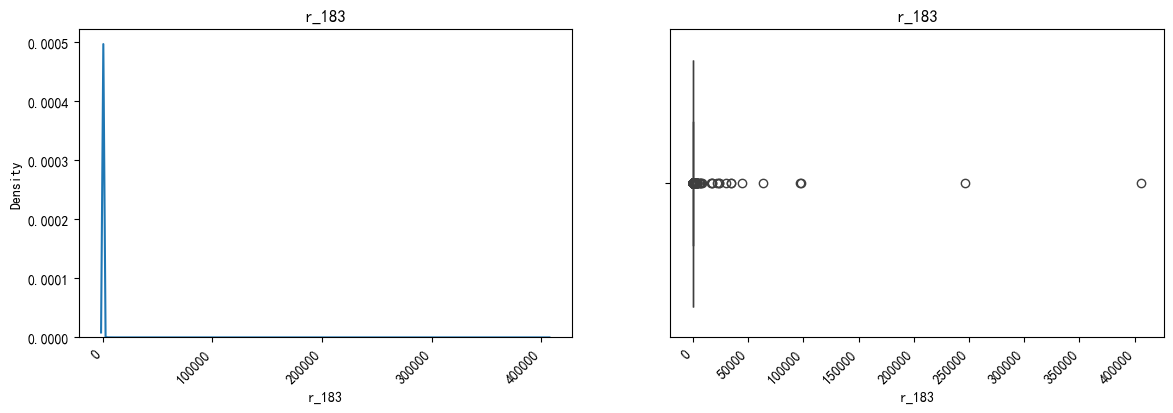

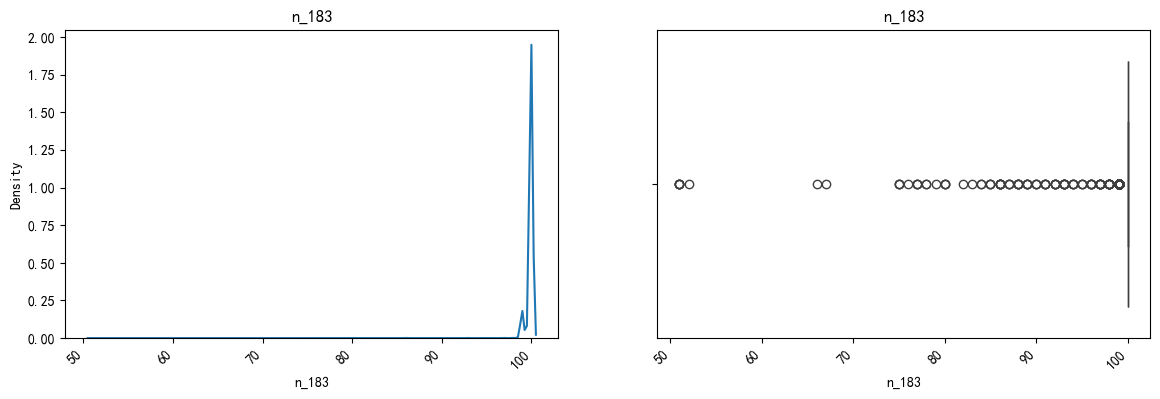

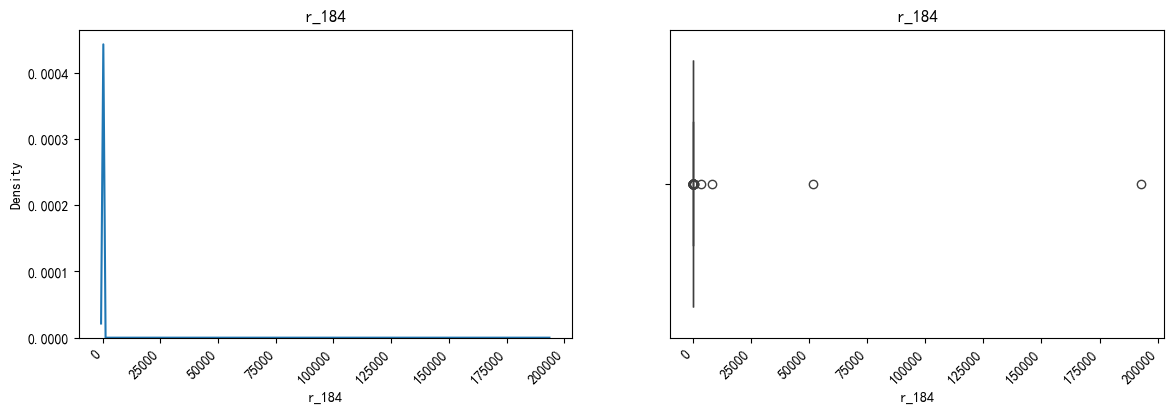

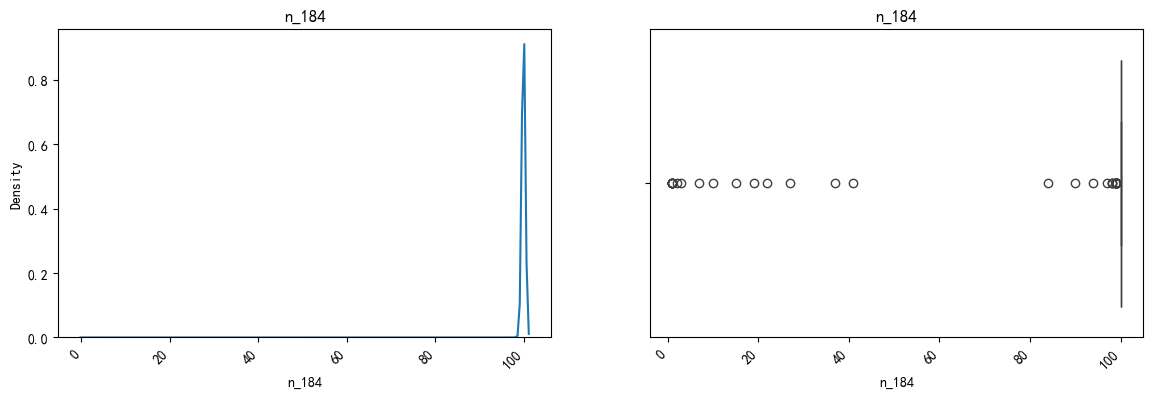

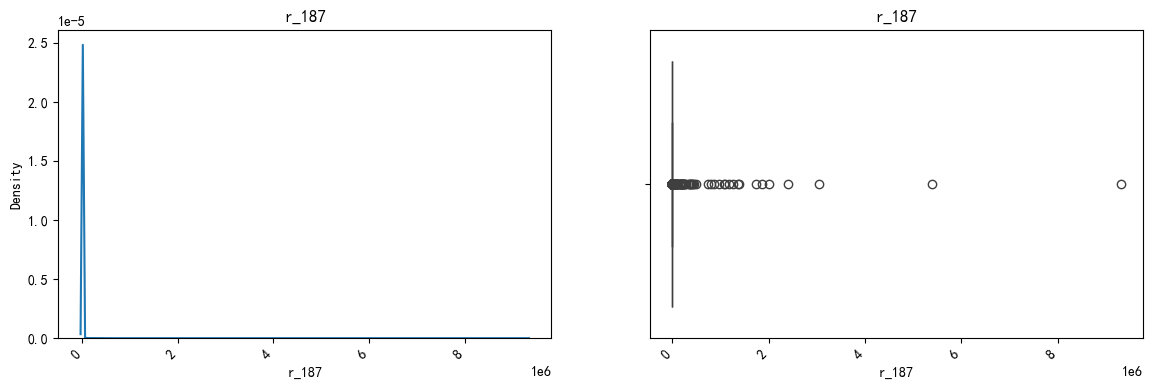

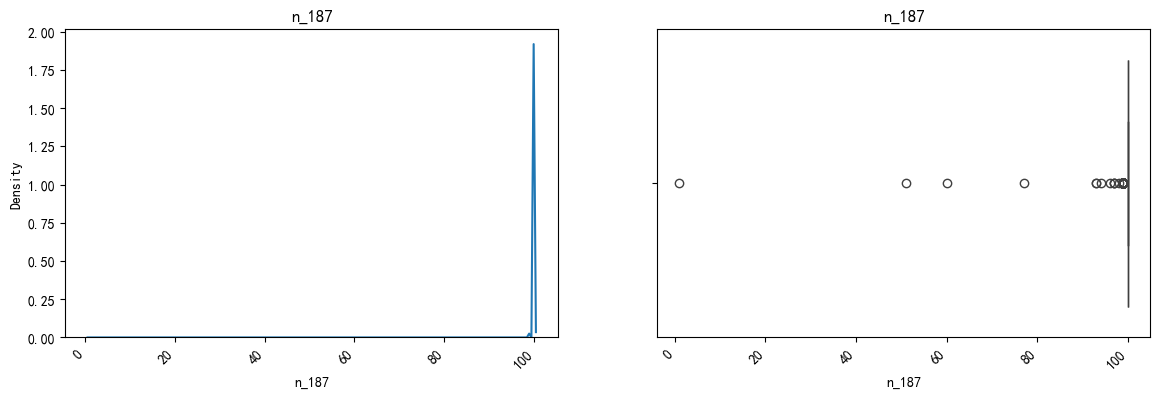

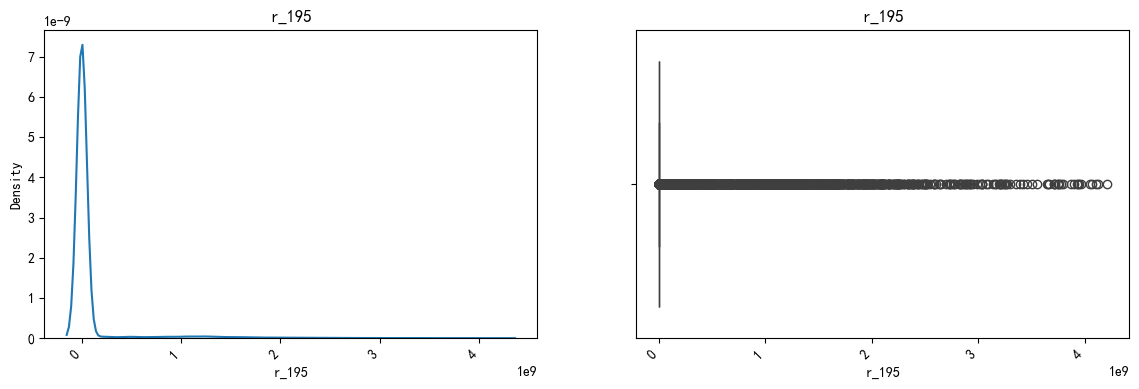

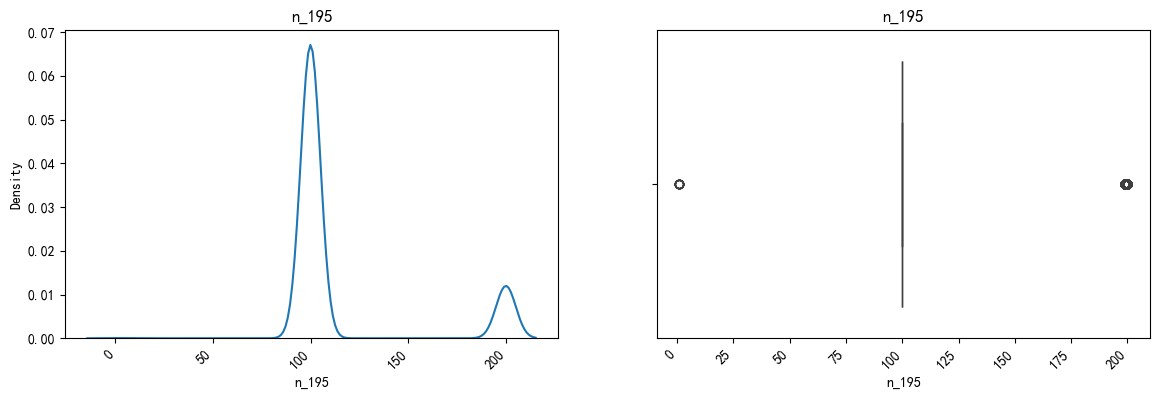

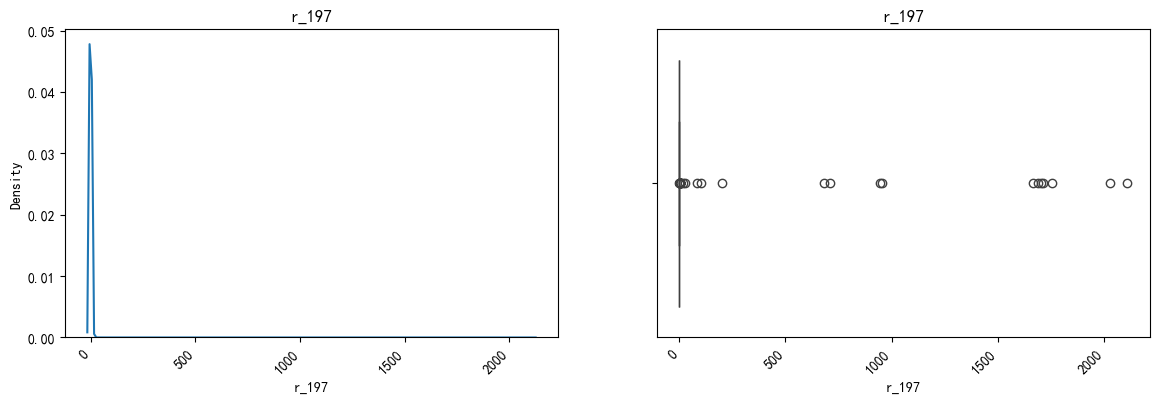

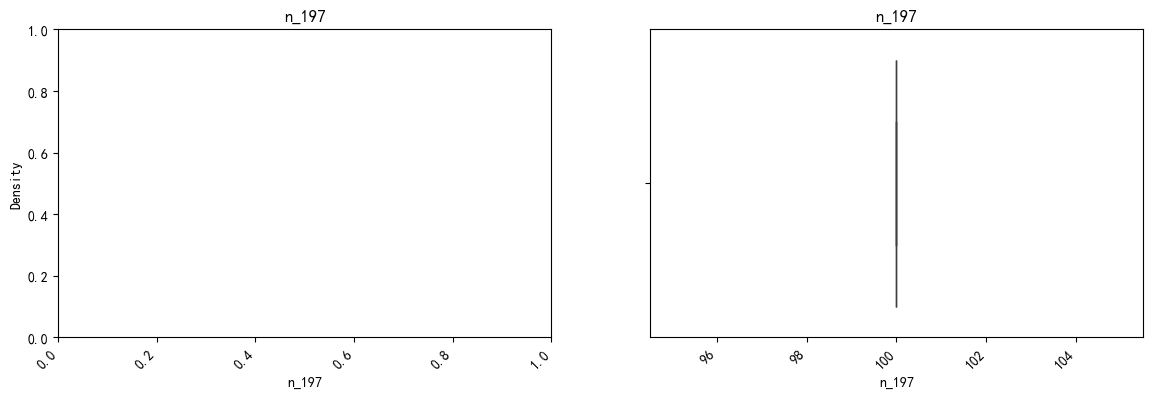

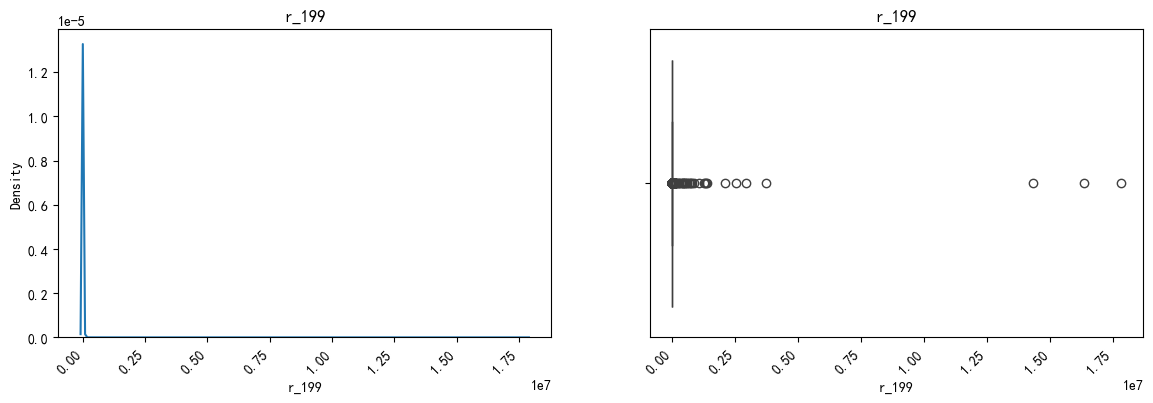

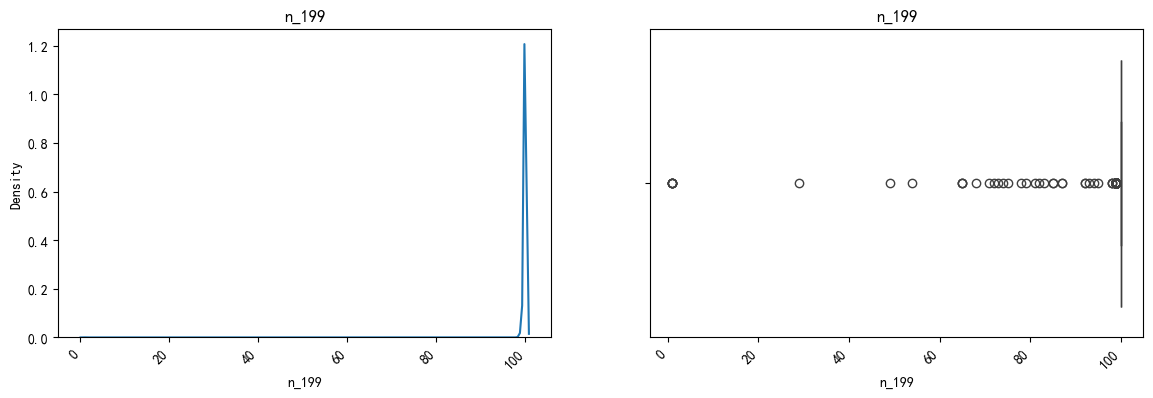

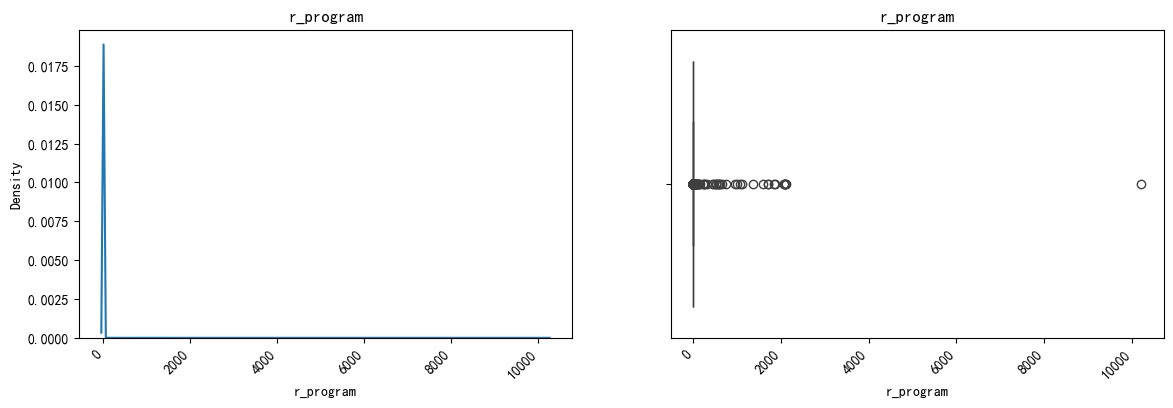

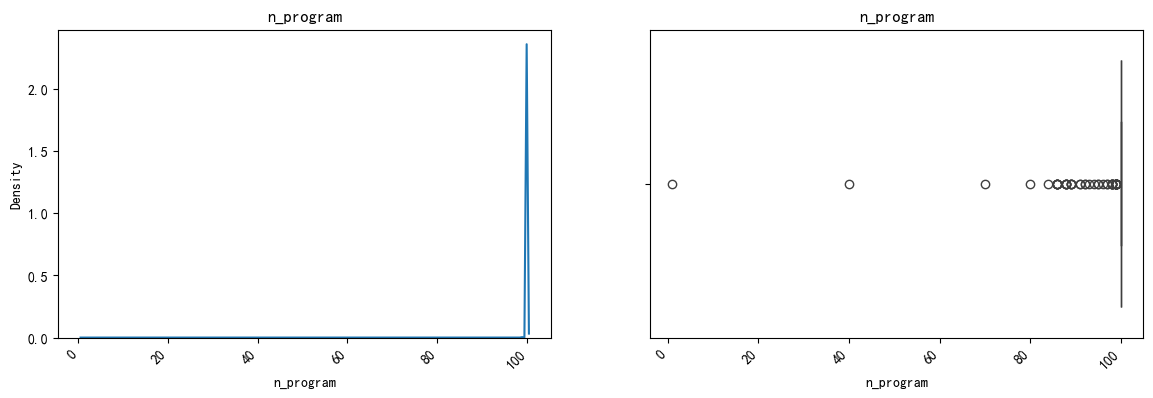

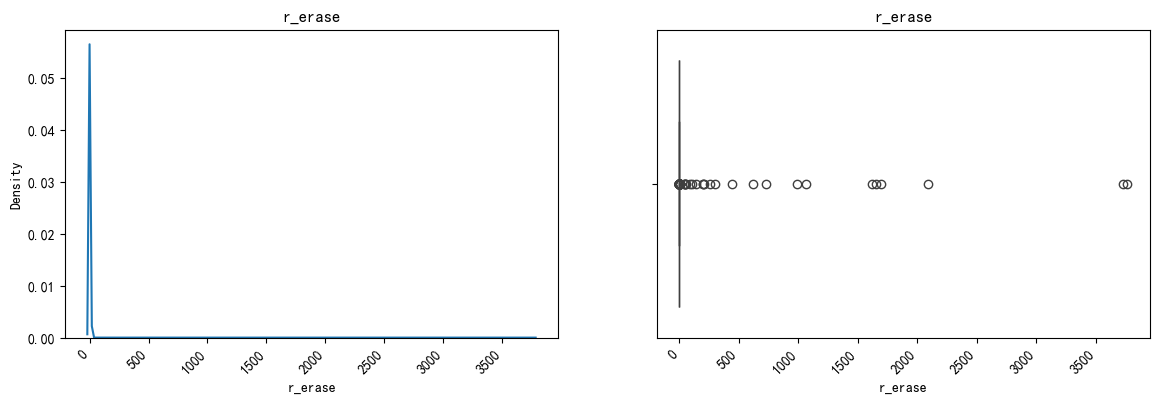

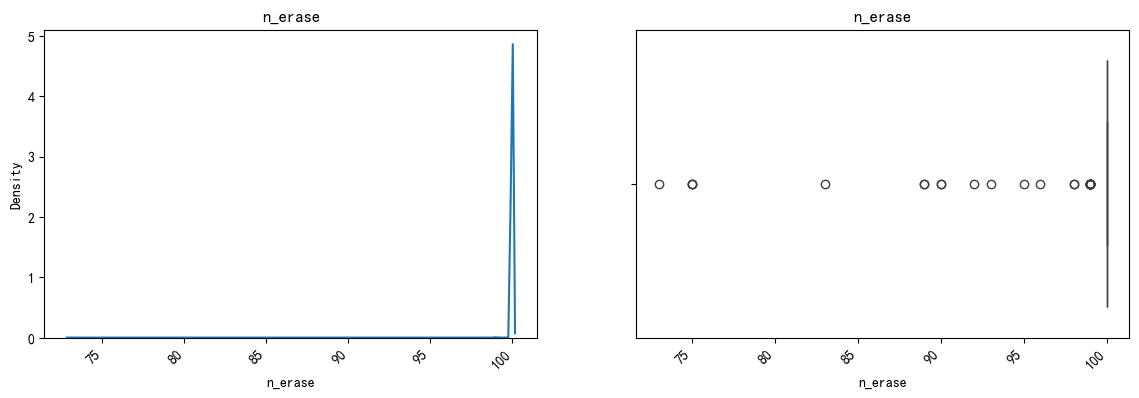

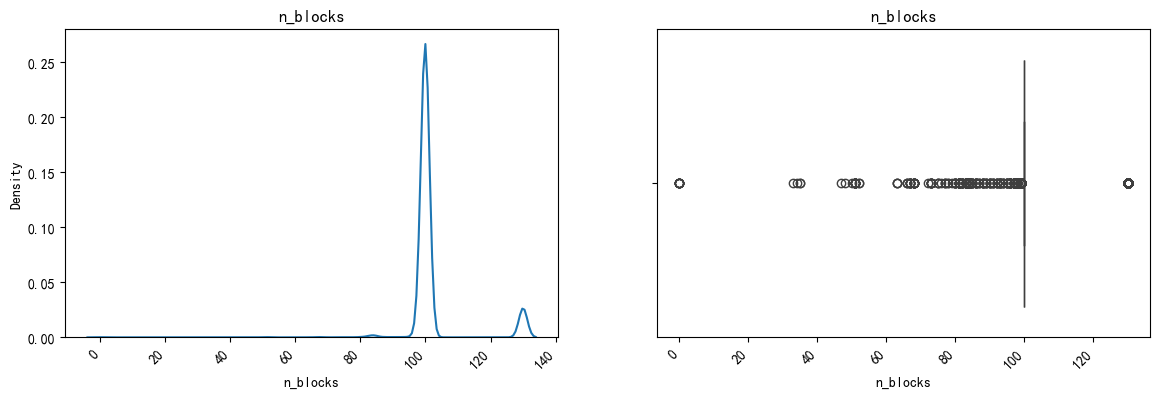

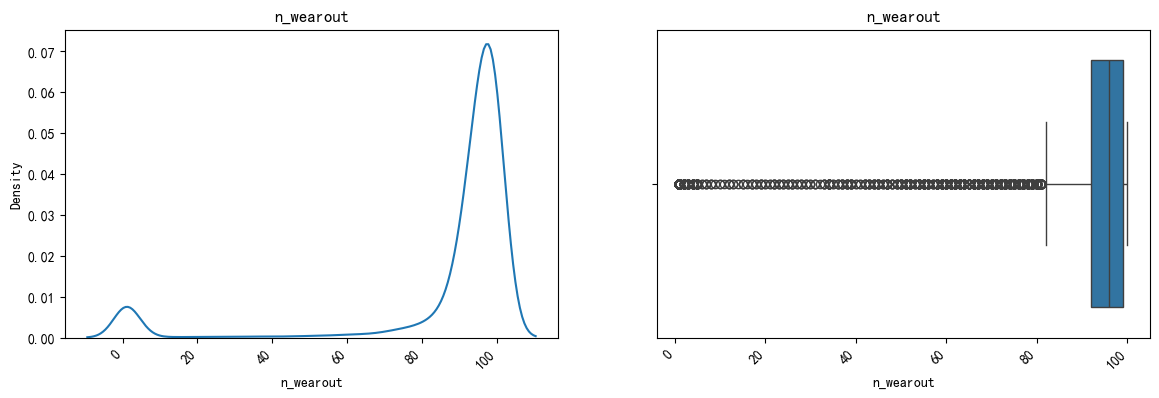

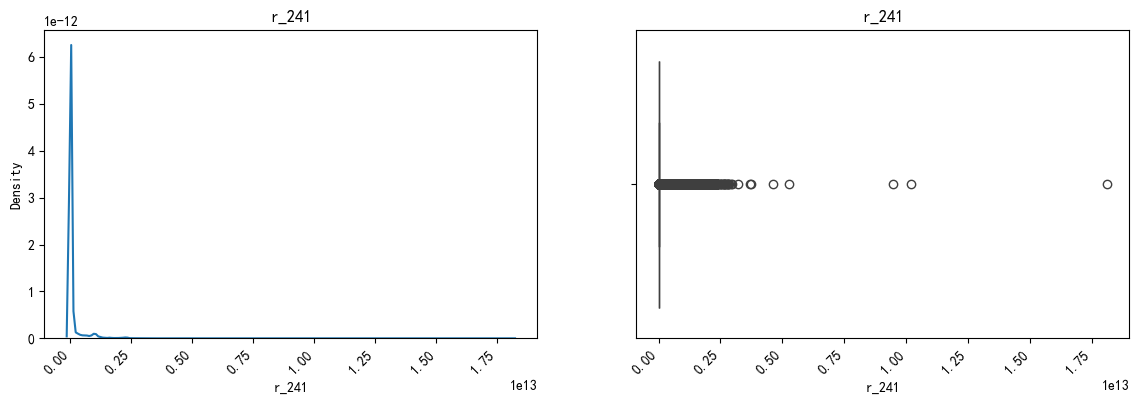

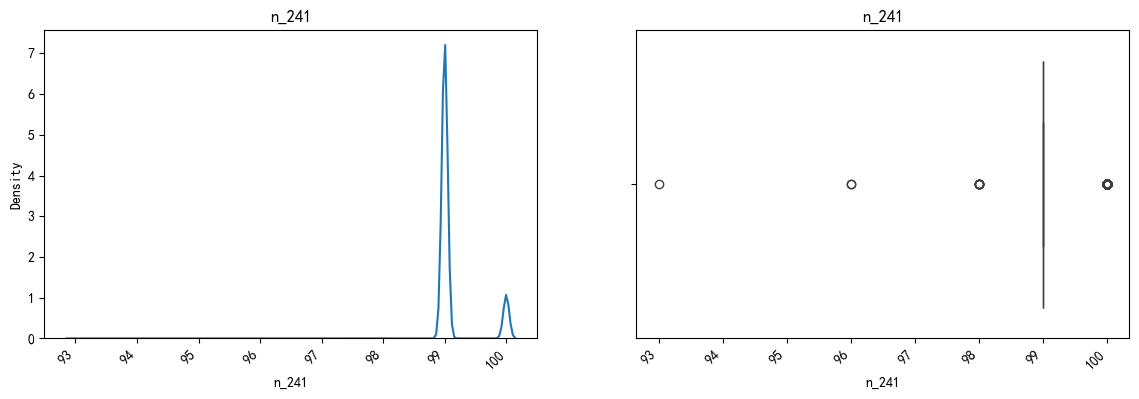

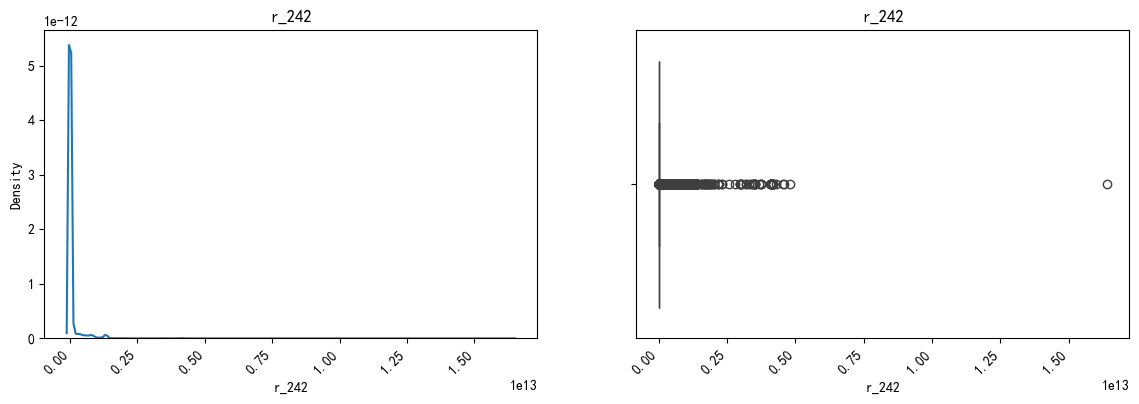

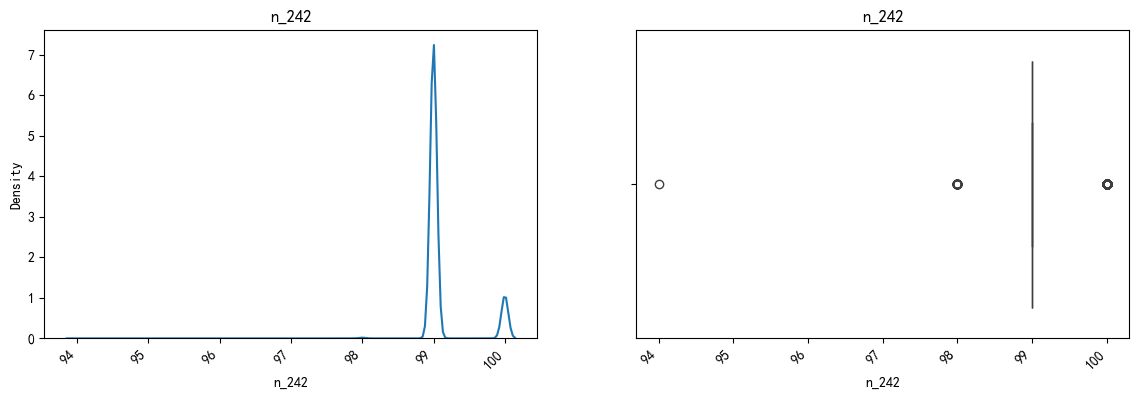

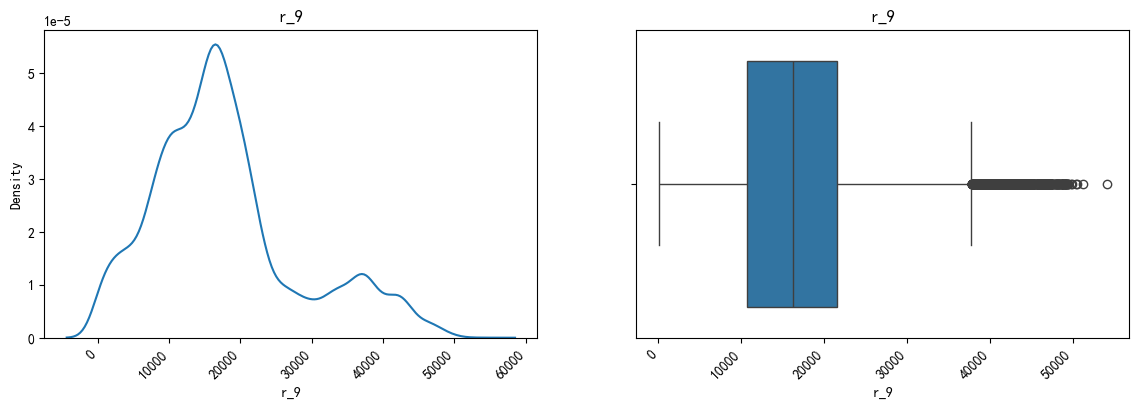

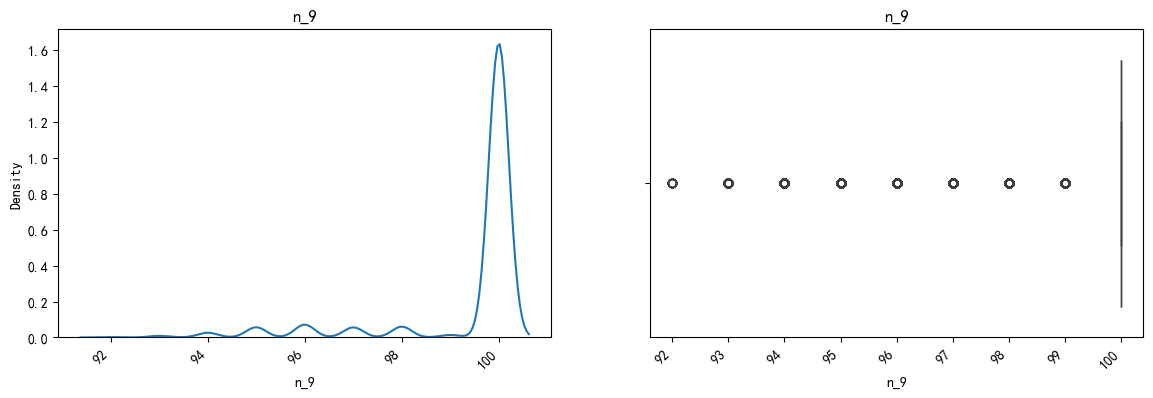

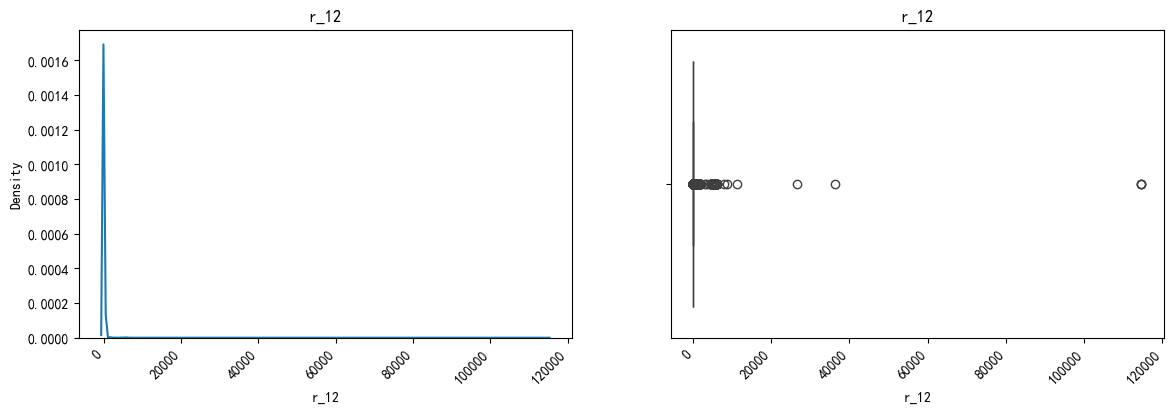

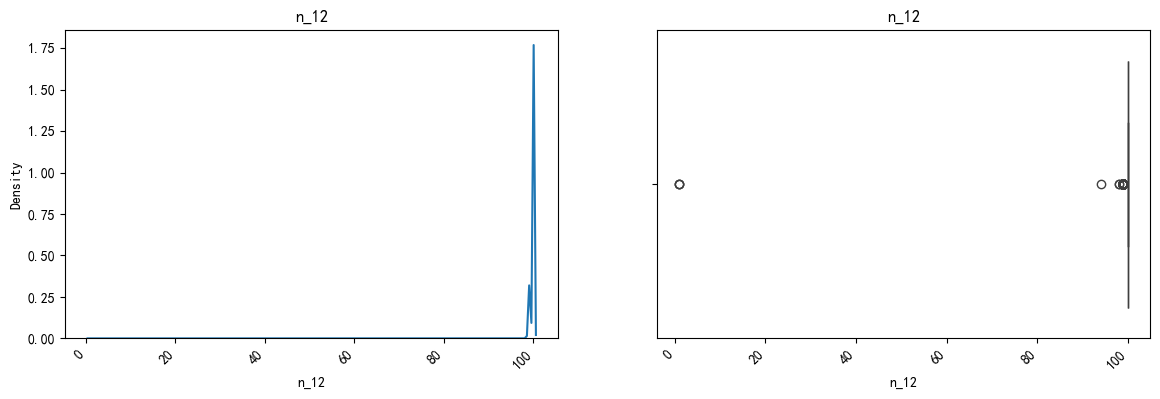

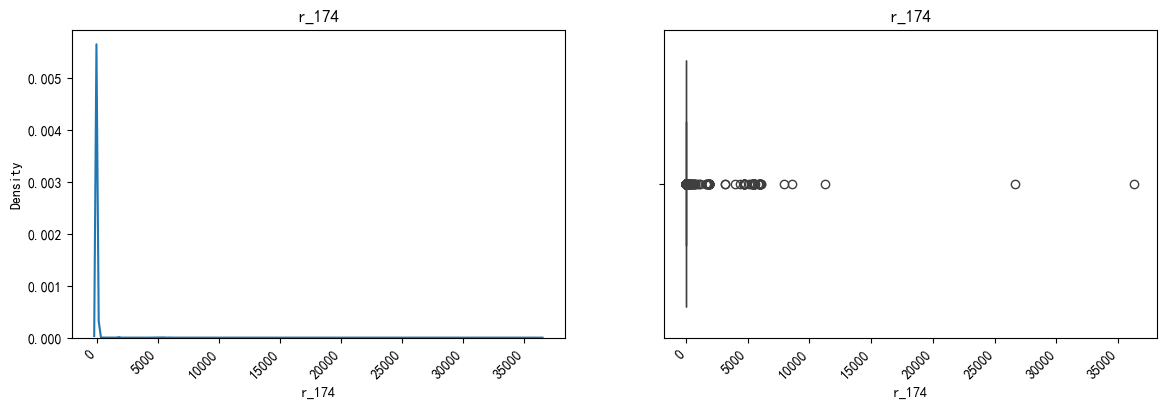

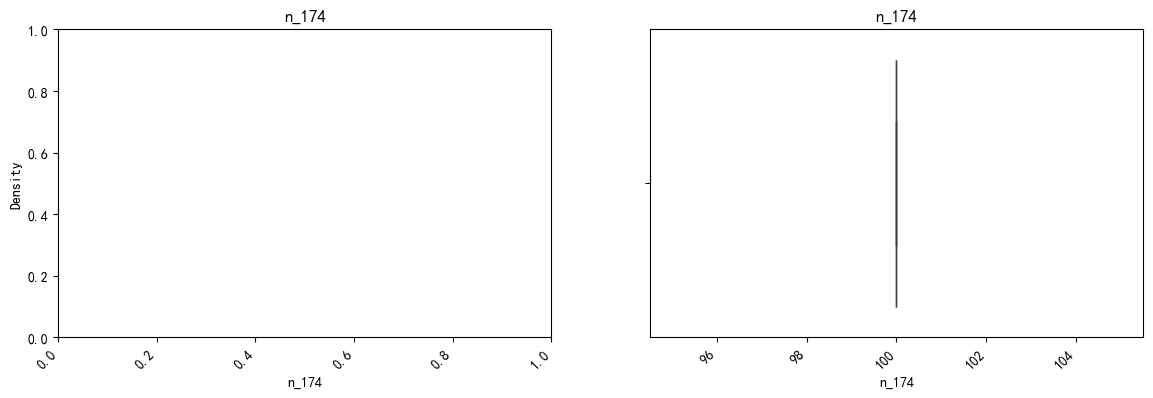

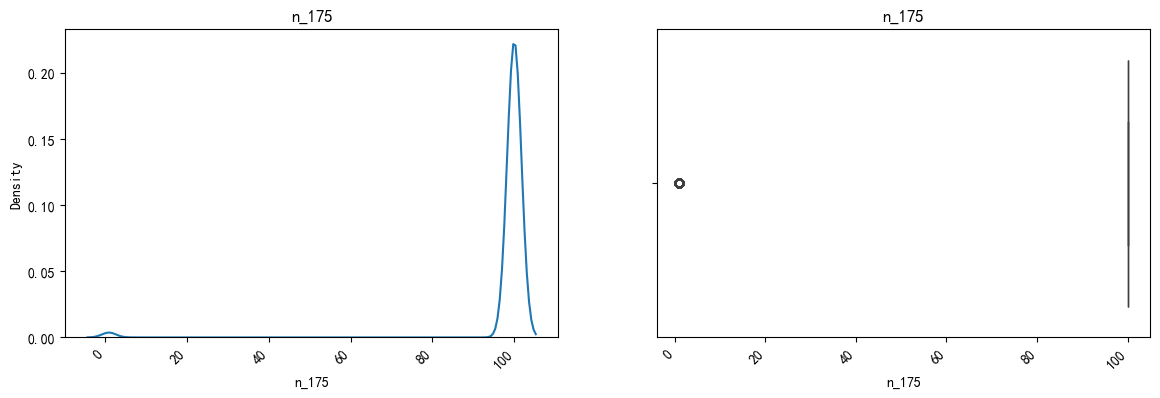

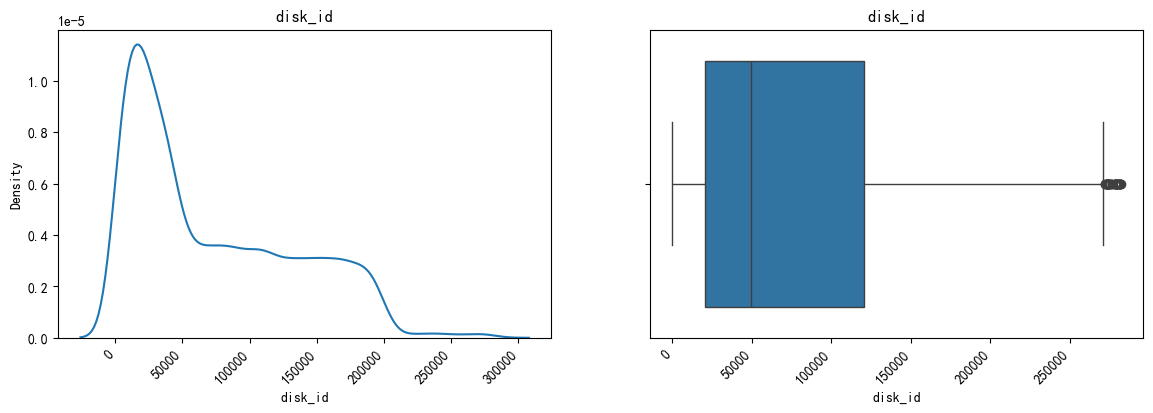

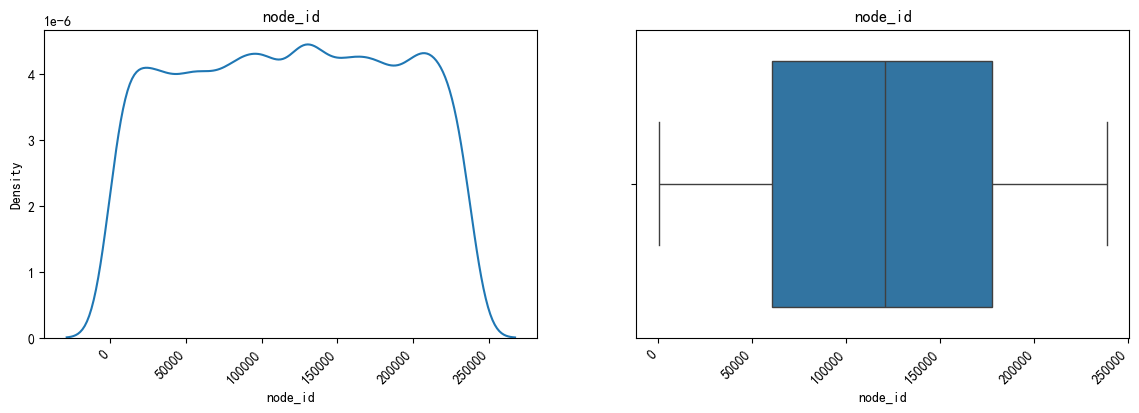

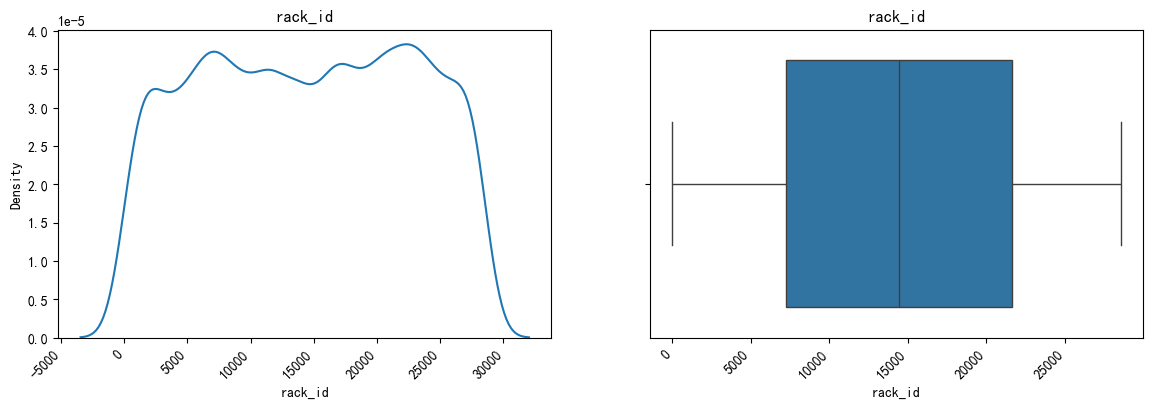

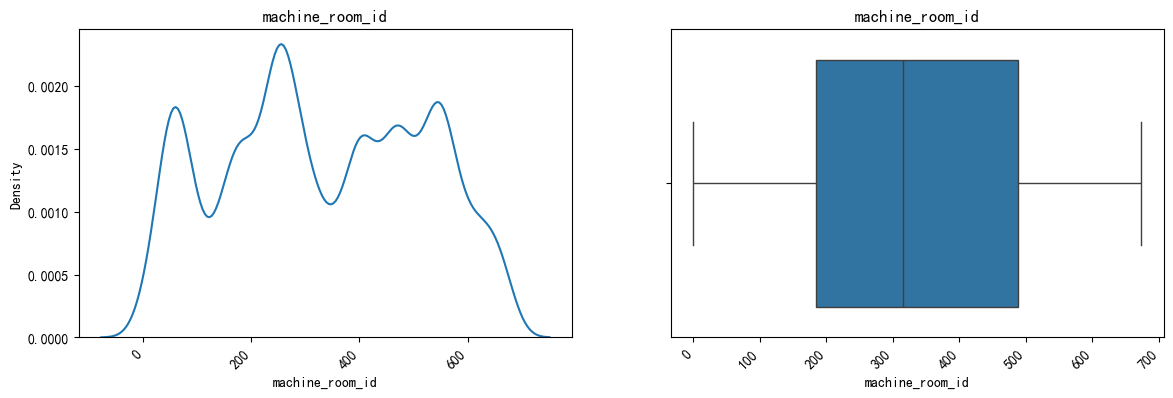

In [15]:
# continuous features
for col in continuous_features:
 
    plt.figure(figsize=(14, 4))
 
    plt.subplot(1,2,1)
    sns.kdeplot(data, x=col)
    plt.title(col)
    plt.xticks(rotation=45, ha='right')
    
    plt.subplot(1,2,2)
    sns.boxplot(data, x=col)
    plt.title(col)
    plt.xticks(rotation=45, ha='right')

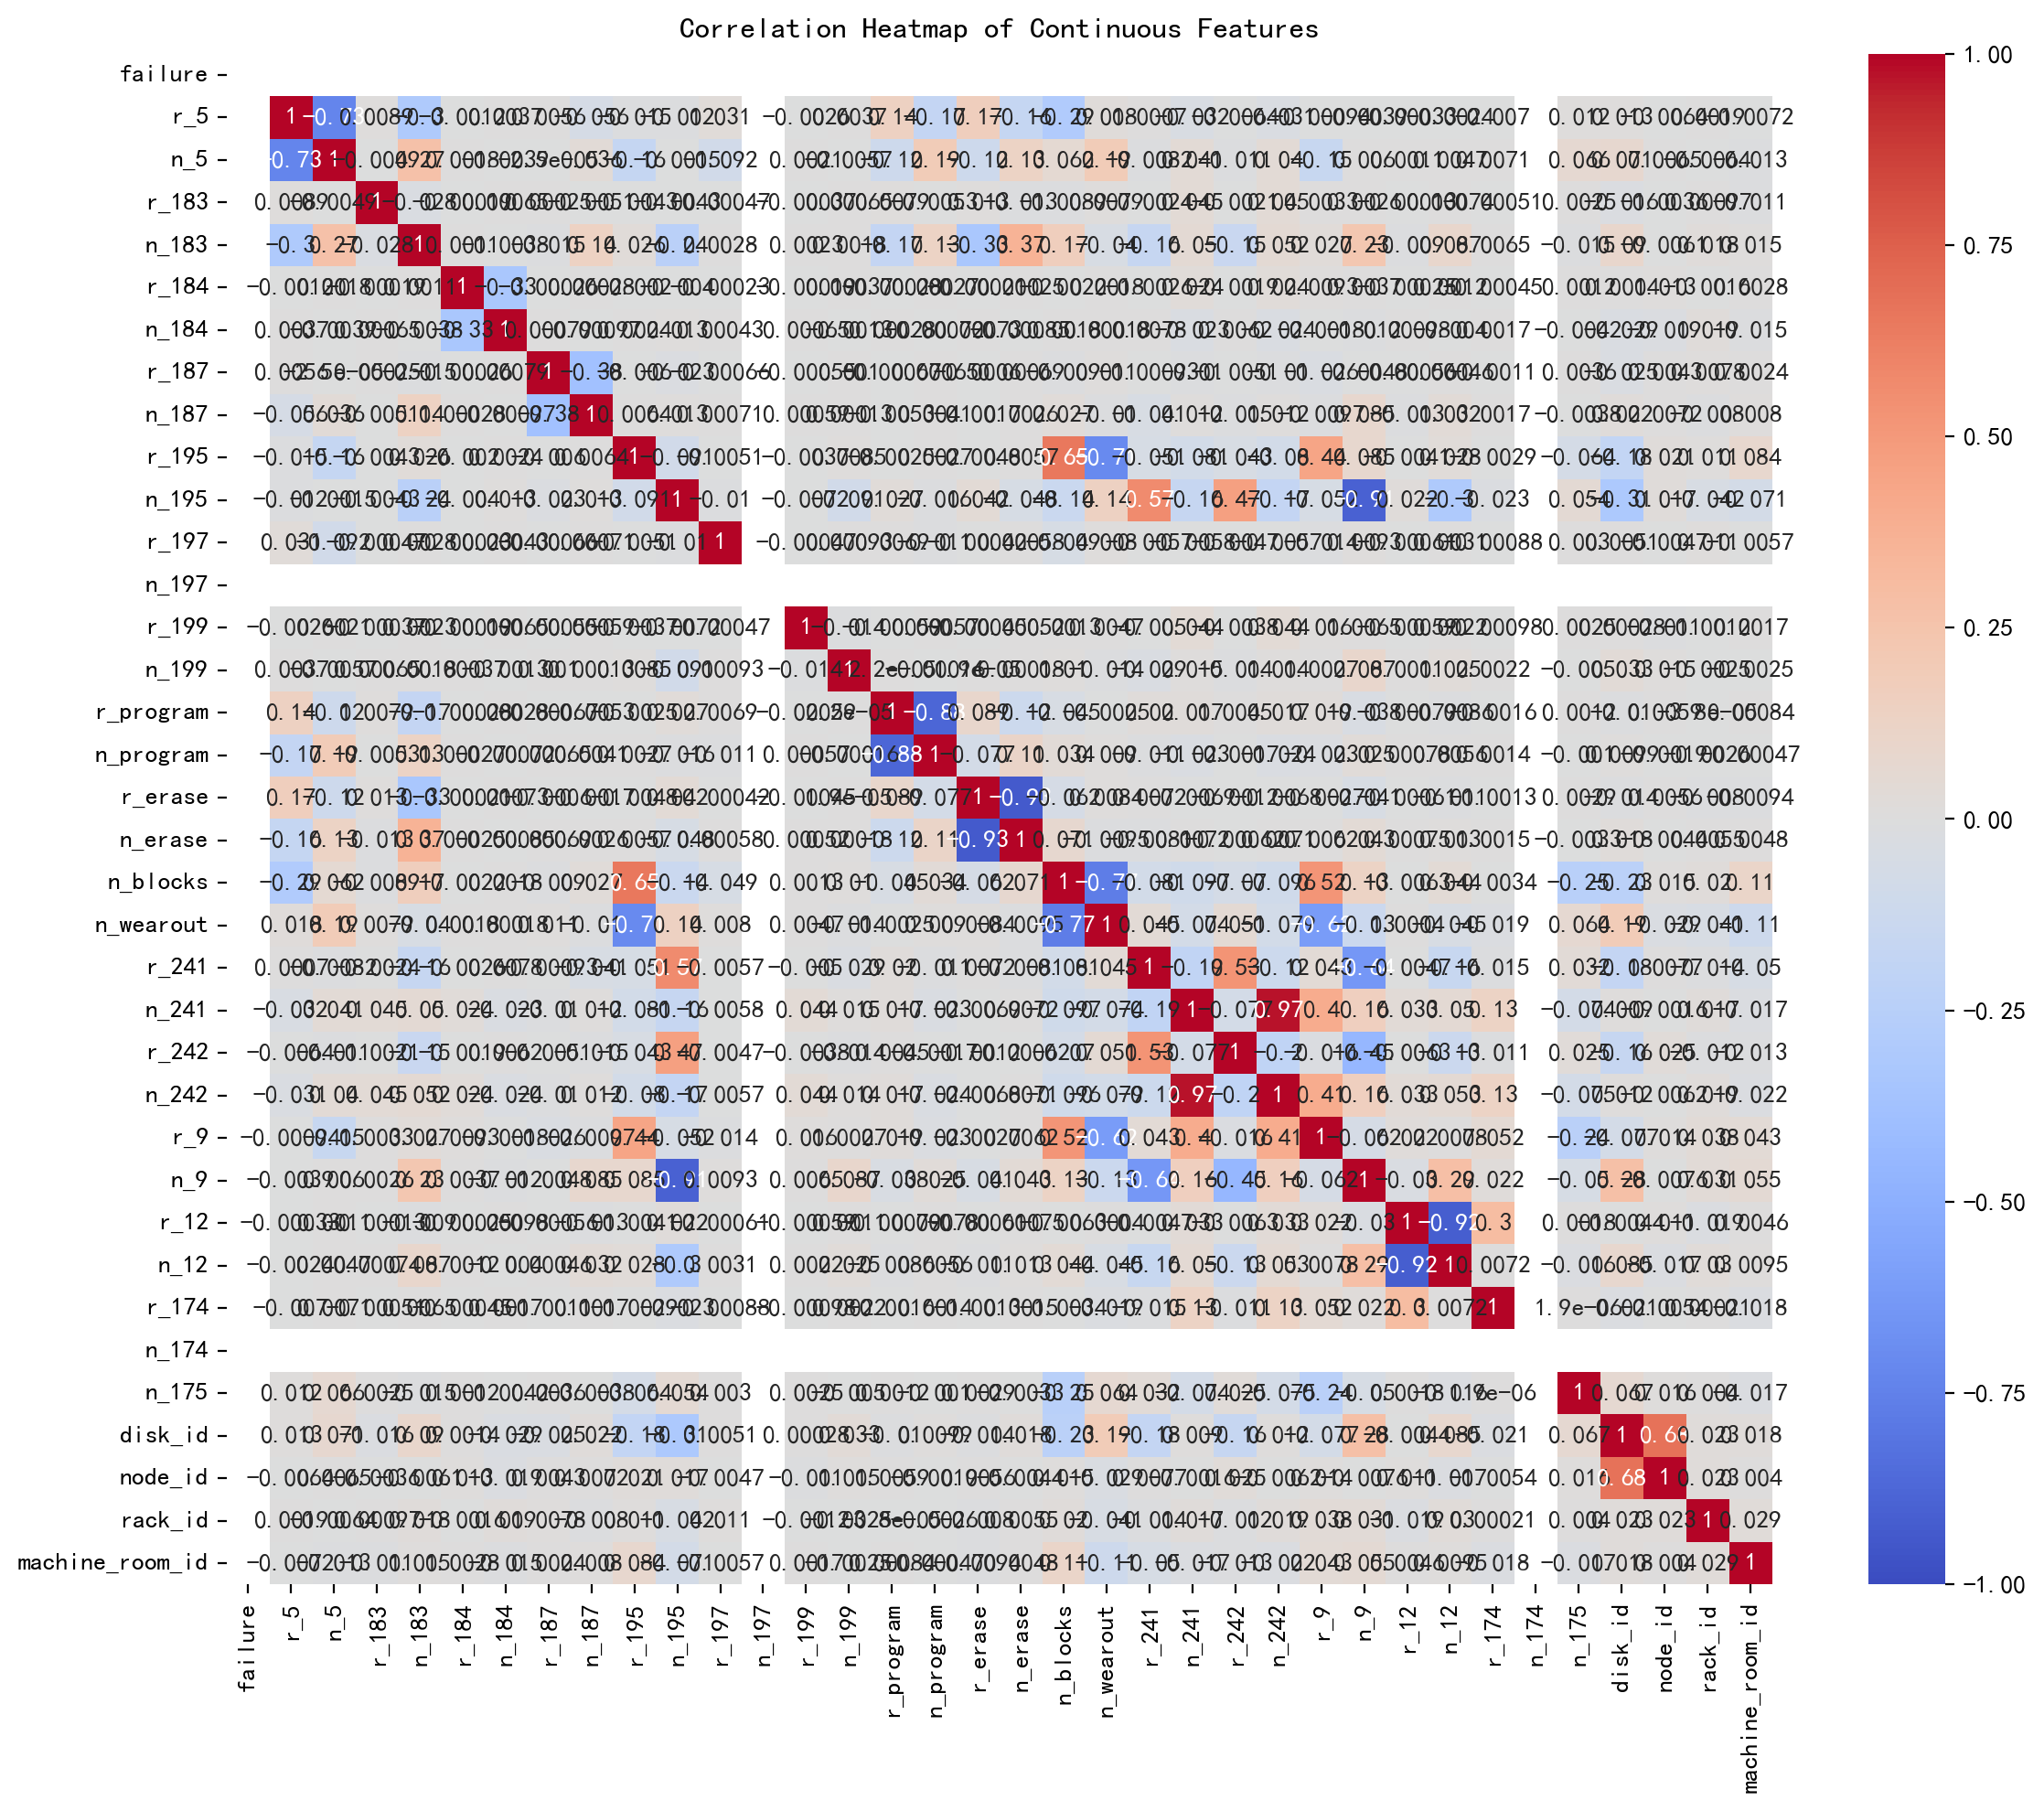

In [16]:
# Heatmap
plt.rcParams['figure.dpi'] = 200
plt.figure(figsize=(12, 10))
corr_matrix= data[continuous_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Continuous Features')
plt.tight_layout()
plt.show()

In [17]:
#对没有顺序的离散变量进行独热编码
# 找到离散变量，排除 failure 列
discrete_lists = [] # 新建一个空列表，用于存放离散变量名
for discrete_features in data.columns:
    if data[discrete_features].dtype == 'object' and discrete_features != 'failure':
        discrete_lists.append(discrete_features)
 
# 离散变量独热编码
data = pd.get_dummies(data, columns=discrete_lists) 
data.columns

Index(['failure', 'r_5', 'n_5', 'r_183', 'n_183', 'r_184', 'n_184', 'r_187',
       'n_187', 'r_195',
       ...
       'failure_time_2019-12-31 22:58:47', 'app_DAE', 'app_DB', 'app_NAS',
       'app_RM', 'app_SS', 'app_WPS', 'app_WS', 'app_WSM', 'app_none'],
      dtype='object', length=17705)

In [18]:
# 对比独热编码前后的列名 即可
data2 = pd.read_csv("ssd_failure_tag.csv")
list_final = [] # 新建一个空列表，用于存放独热编码后新增的特征名
for i in data.columns:
    if i not in data2.columns:
       list_final.append(i) # 这里打印出来的就是独热编码后的特征名
for i in list_final:
    data[i]=data[i].astype(int)#将bool型转换为数值型
print(list_final)
print(data.head())

['model_A1', 'model_A2', 'model_A3', 'model_A4', 'model_A5', 'model_A6', 'model_B1', 'model_B2', 'model_B3', 'model_C1', 'model_C2', 'failure_time_2018-01-02 03:09:38', 'failure_time_2018-01-02 19:15:32', 'failure_time_2018-01-02 22:45:16', 'failure_time_2018-01-03 03:23:44', 'failure_time_2018-01-03 03:29:27', 'failure_time_2018-01-03 05:03:03', 'failure_time_2018-01-03 12:44:32', 'failure_time_2018-01-04 01:13:17', 'failure_time_2018-01-04 03:19:14', 'failure_time_2018-01-04 03:32:59', 'failure_time_2018-01-04 06:30:47', 'failure_time_2018-01-04 22:50:36', 'failure_time_2018-01-05 02:10:51', 'failure_time_2018-01-05 03:00:19', 'failure_time_2018-01-05 03:01:17', 'failure_time_2018-01-05 04:50:47', 'failure_time_2018-01-05 14:37:22', 'failure_time_2018-01-05 14:37:23', 'failure_time_2018-01-06 03:04:14', 'failure_time_2018-01-06 03:28:27', 'failure_time_2018-01-06 08:40:48', 'failure_time_2018-01-07 03:23:09', 'failure_time_2018-01-07 09:37:30', 'failure_time_2018-01-07 21:06:48', 'fa

In [19]:
from sklearn.model_selection import train_test_split
x = data.drop(['failure'], axis=1)  # 特征，axis=1表示按列删除
y = data['failure'] # 标签
# 按照8:2划分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)  # 80%训练集，20%测试集
print(f"训练集形状：{x_train.shape},测试集形状：{x_test.shape}")

训练集形状：(14709, 17704),测试集形状：(3678, 17704)


In [20]:
from sklearn.ensemble import RandomForestClassifier #随机森林分类器
 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # 用于评估分类器性能的指标
from sklearn.metrics import classification_report, confusion_matrix #用于生成分类报告和混淆矩阵
import warnings #用于忽略警告信息
warnings.filterwarnings("ignore") # 忽略所有警告信息
# --- 1. 默认参数的随机森林 ---
# 评估基准模型，这里确实不需要验证集
print("--- 1. 默认参数随机森林 (训练集 -> 测试集) ---")
import time # 这里介绍一个新的库，time库，主要用于时间相关的操作，因为调参需要很长时间，记录下会帮助后人知道大概的时长
start_time = time.time() # 记录开始时间
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train) # 在训练集上训练
rf_pred = rf_model.predict(x_test) # 在测试集上预测
end_time = time.time() # 记录结束时间
 
print(f"训练与预测耗时: {end_time - start_time:.4f} 秒")
print("\n默认随机森林 在测试集上的分类报告：")
print(classification_report(y_test, rf_pred))
print("默认随机森林 在测试集上的混淆矩阵：")
print(confusion_matrix(y_test, rf_pred))

--- 1. 默认参数随机森林 (训练集 -> 测试集) ---
训练与预测耗时: 36.5225 秒

默认随机森林 在测试集上的分类报告：
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3678

    accuracy                           1.00      3678
   macro avg       1.00      1.00      1.00      3678
weighted avg       1.00      1.00      1.00      3678

默认随机森林 在测试集上的混淆矩阵：
[[3678]]


In [21]:
 
#贝叶斯优化调参
from sklearn.ensemble import RandomForestClassifier #随机森林分类器
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # 用于评估分类器性能的指标
from sklearn.metrics import classification_report, confusion_matrix #用于生成分类报告和混淆矩阵
import warnings #用于忽略警告信息
warnings.filterwarnings("ignore") # 忽略所有警告信息
# --- 1. 默认参数的随机森林 ---
# 评估基准模型，这里确实不需要验证集
print("--- 1. 默认参数随机森林 (训练集 -> 测试集) ---")
import time # 这里介绍一个新的库，time库，主要用于时间相关的操作，因为调参需要很长时间，记录下会帮助后人知道大概的时长
start_time = time.time() # 记录开始时间
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train) # 在训练集上训练
rf_pred = rf_model.predict(x_test) # 在测试集上预测
end_time = time.time() # 记录结束时间
 
print(f"训练与预测耗时: {end_time - start_time:.4f} 秒")
print("\n默认随机森林 在测试集上的分类报告：")
print(classification_report(y_test, rf_pred))
print("默认随机森林 在测试集上的混淆矩阵：")
print(confusion_matrix(y_test, rf_pred))

--- 1. 默认参数随机森林 (训练集 -> 测试集) ---
训练与预测耗时: 2.4080 秒

默认随机森林 在测试集上的分类报告：
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3678

    accuracy                           1.00      3678
   macro avg       1.00      1.00      1.00      3678
weighted avg       1.00      1.00      1.00      3678

默认随机森林 在测试集上的混淆矩阵：
[[3678]]


In [22]:
# 用shap库画特征重要性图
import shap
# 初始化 SHAP 解释器
explainer = shap.TreeExplainer(rf_model)
# 计算 SHAP 值（基于测试集），这个shap_values是一个numpy数组，表示每个特征对每个样本的贡献值
# 这里大家先知道这是个numpy数组即可，我们后面学习完numpy在来回头解读这个值
shap_values = explainer.shap_values(x_test) # 这个计算耗时
print("shap_values shape:", shap_values.shape if isinstance(shap_values, np.ndarray) else [val.shape for val in shap_values])

if isinstance(shap_values, np.ndarray):
    if shap_values.ndim >= 3:
        print("shap_values[:, :, 0] shape:", shap_values[:, :, 0].shape)
    else:
        print("shap_values 维度小于 3，无法访问 shap_values[:, :, 0]")
else:
    print("shap_values 是一个列表，无法直接访问 shap_values[:, :, 0]")

print("X_test shape:", x_test.shape)

shap_values shape: (3678, 17704)
shap_values 维度小于 3，无法访问 shap_values[:, :, 0]
X_test shape: (3678, 17704)


--- 1. SHAP 特征重要性条形图 ---


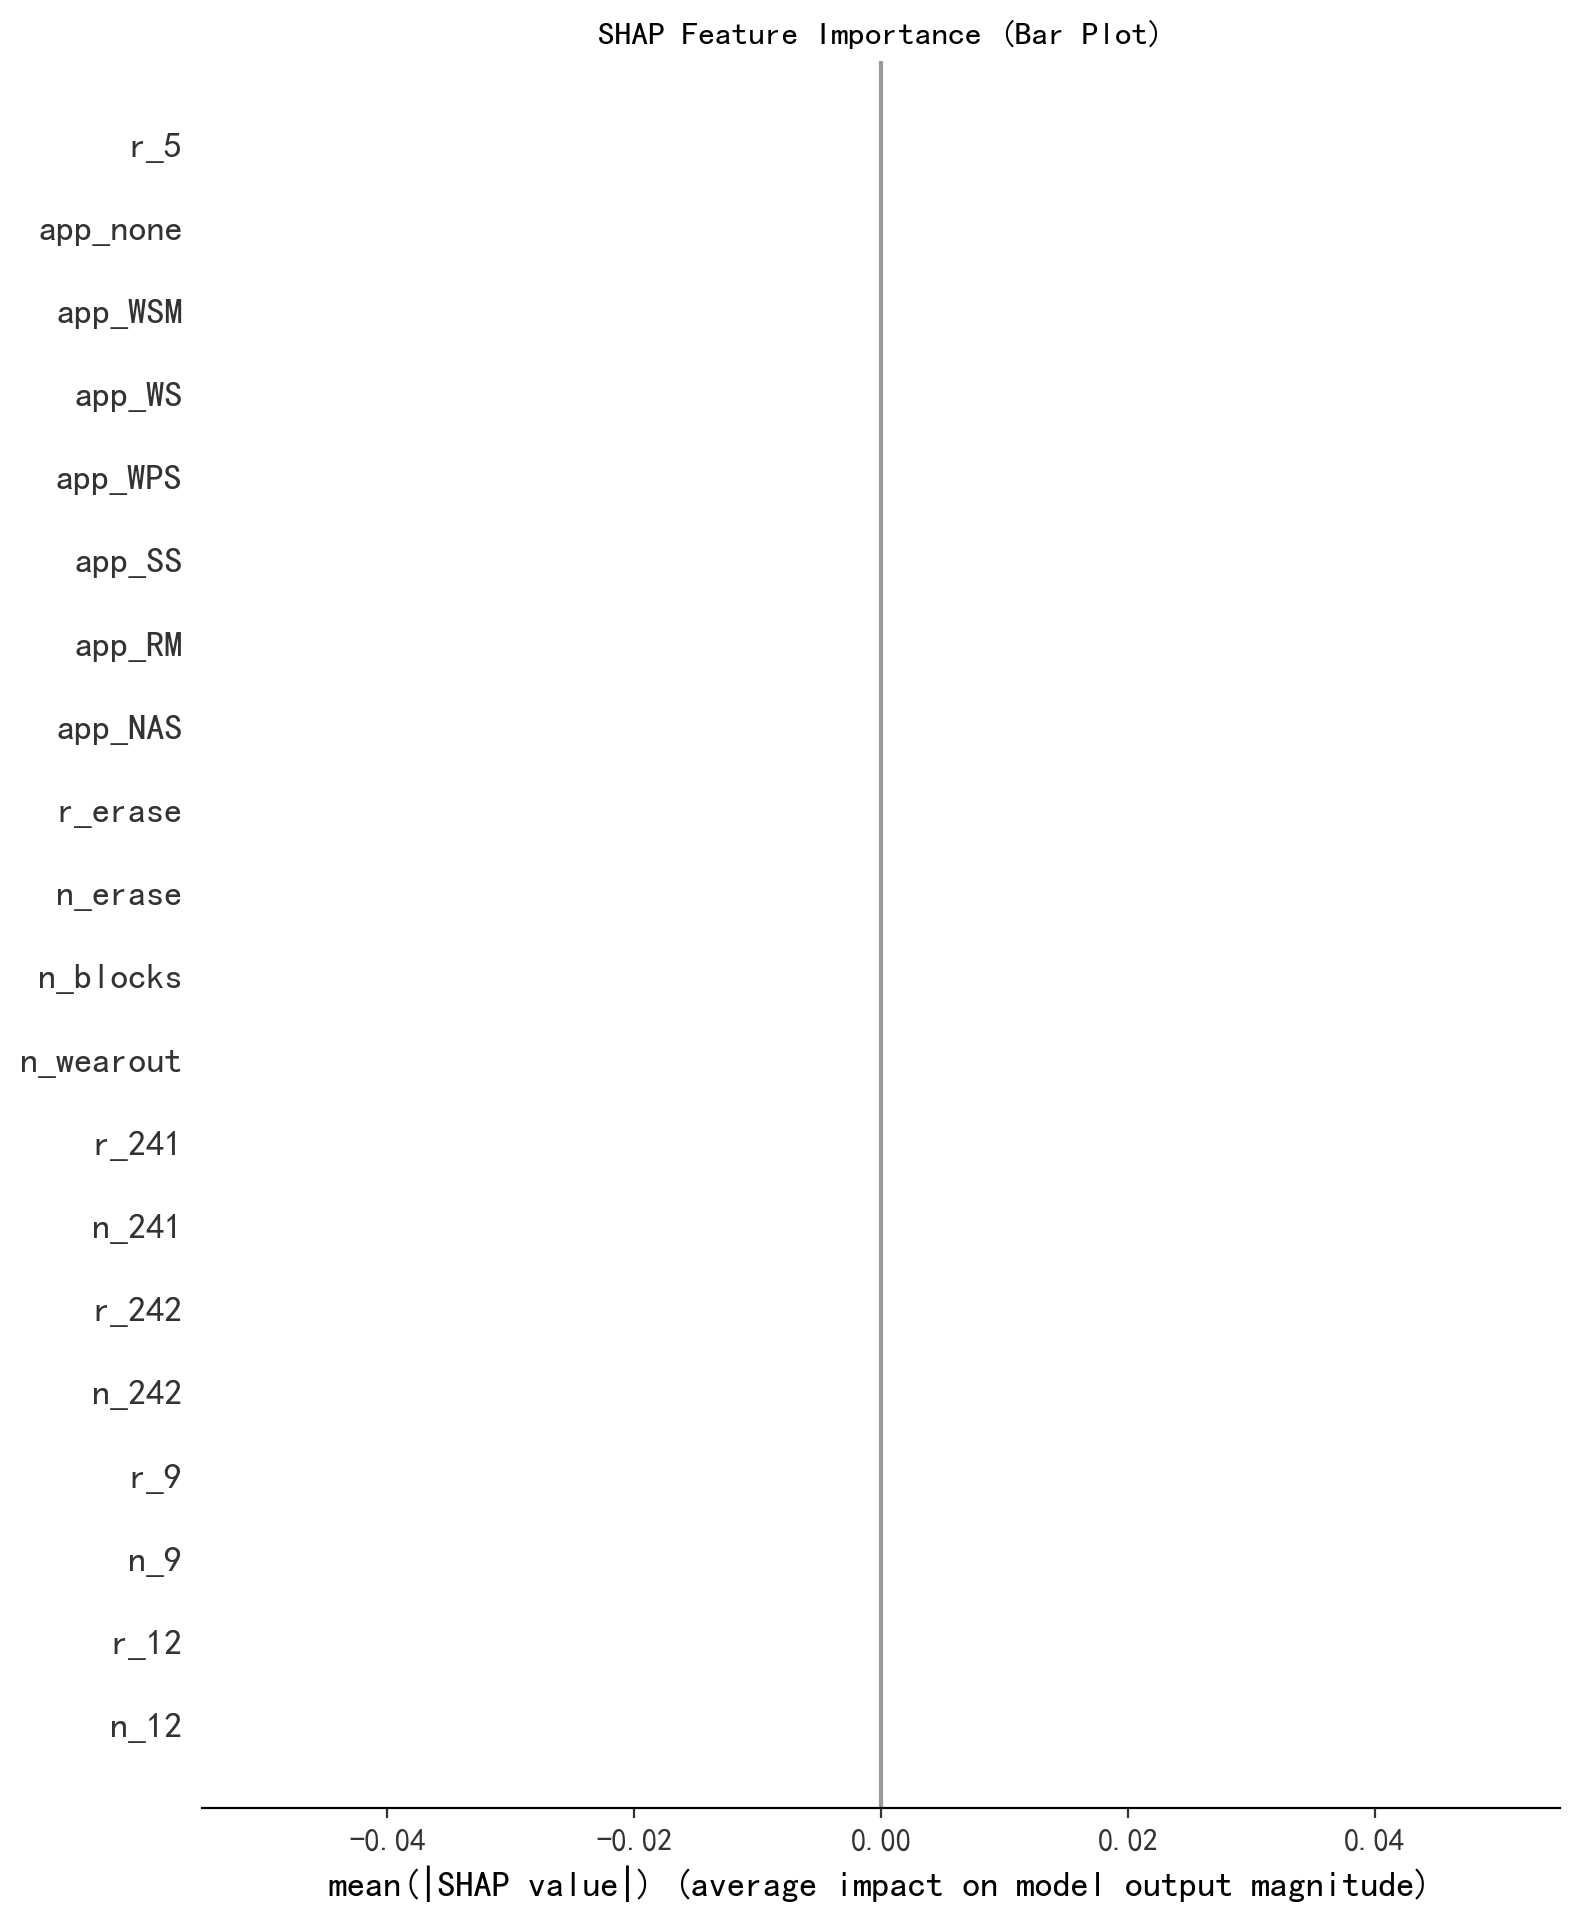

In [23]:
# --- 1. SHAP 特征重要性条形图 (Summary Plot - Bar) ---
print("--- 1. SHAP 特征重要性条形图 ---")
# 修改此处，直接使用 shap_values
shap.summary_plot(shap_values, x_test, plot_type="bar", show=False)  
plt.title("SHAP Feature Importance (Bar Plot)")
plt.show()

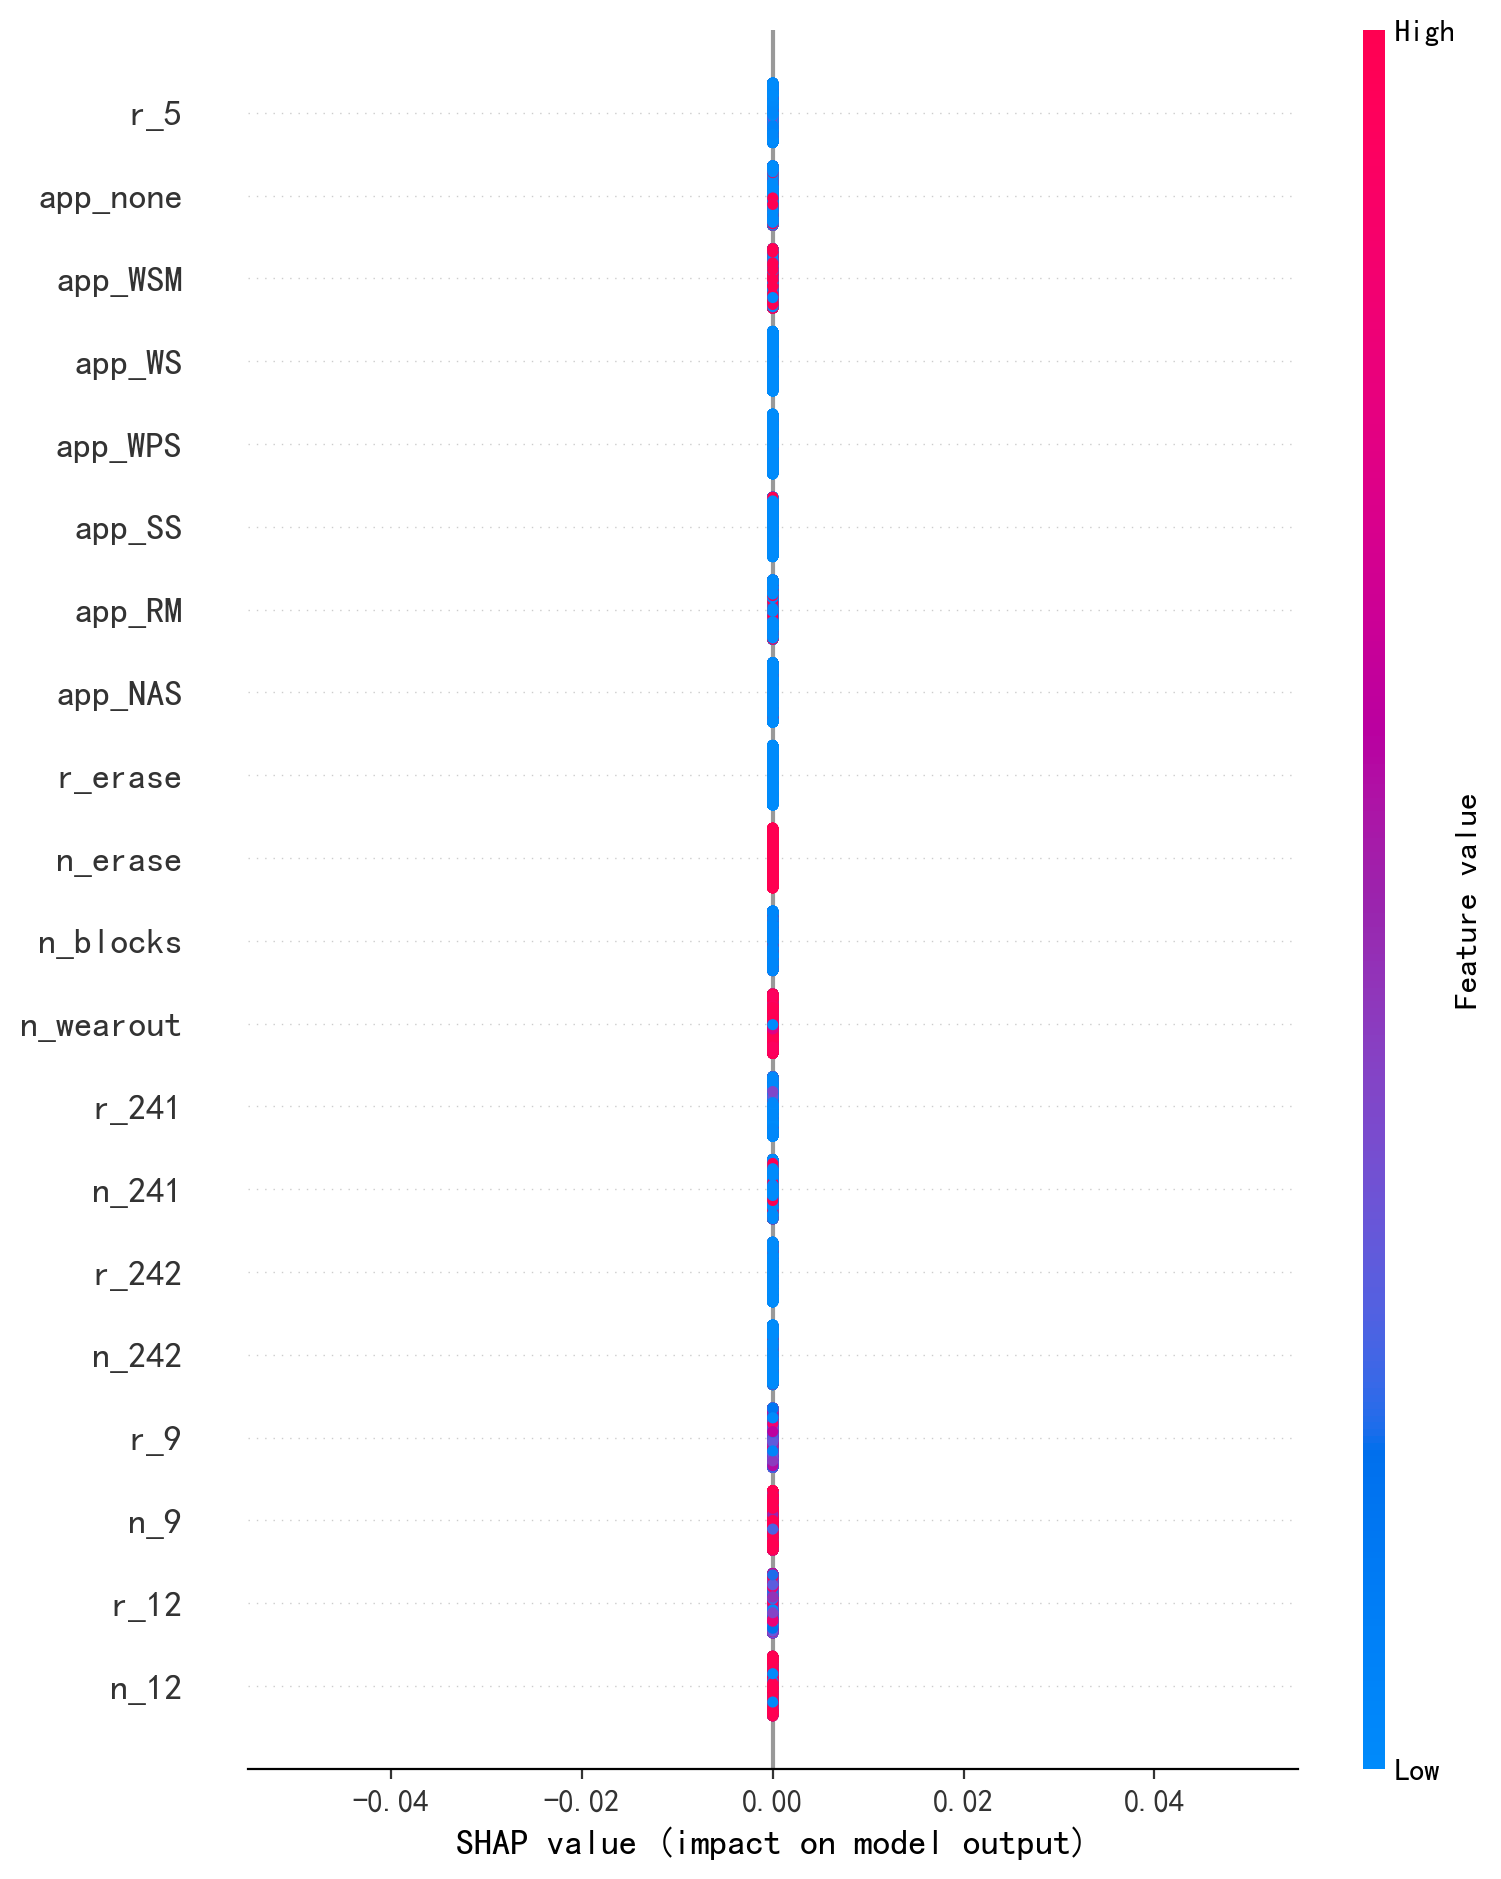

In [24]:
shap.summary_plot(shap_values, x_test)

--- 3. SHAP 依赖图 ---


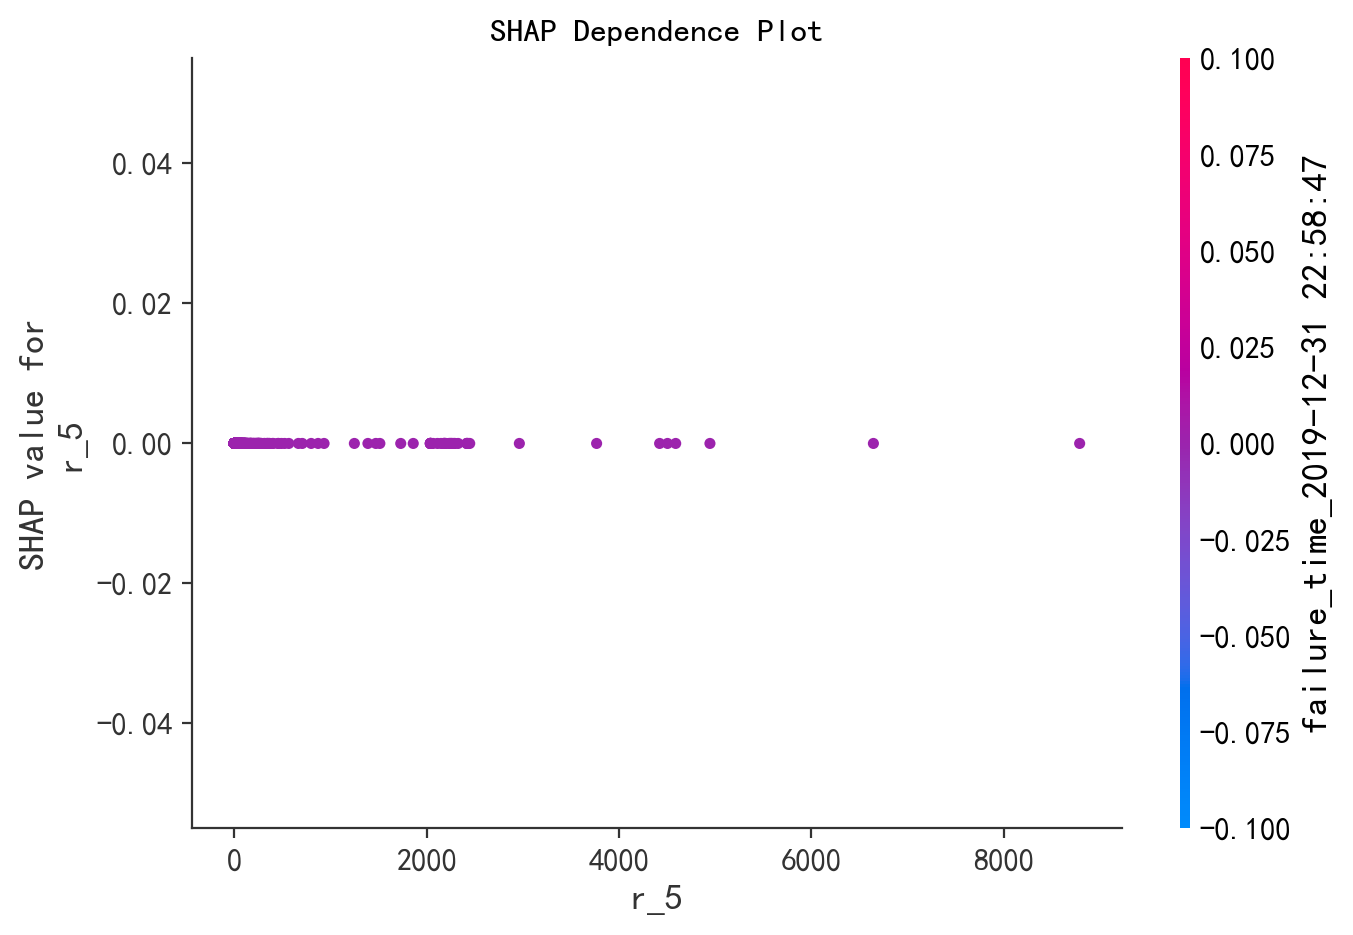

In [25]:
# --- 3. SHAP 依赖图 (Dependence Plot) ---
print("--- 3. SHAP 依赖图 ---")
# 选择最重要的特征进行可视化（这里用第一个重要特征）
shap.dependence_plot('r_5', shap_values, x_test,interaction_index="failure_time_2019-12-31 22:58:47", show=False)
plt.title("SHAP Dependence Plot")
plt.show()

In [26]:
# 打印特征名，确认是否存在拼写错误
print(x_test.columns)

Index(['r_5', 'n_5', 'r_183', 'n_183', 'r_184', 'n_184', 'r_187', 'n_187',
       'r_195', 'n_195',
       ...
       'failure_time_2019-12-31 22:58:47', 'app_DAE', 'app_DB', 'app_NAS',
       'app_RM', 'app_SS', 'app_WPS', 'app_WS', 'app_WSM', 'app_none'],
      dtype='object', length=17704)


--- 4. SHAP 单个样本解释图 ---


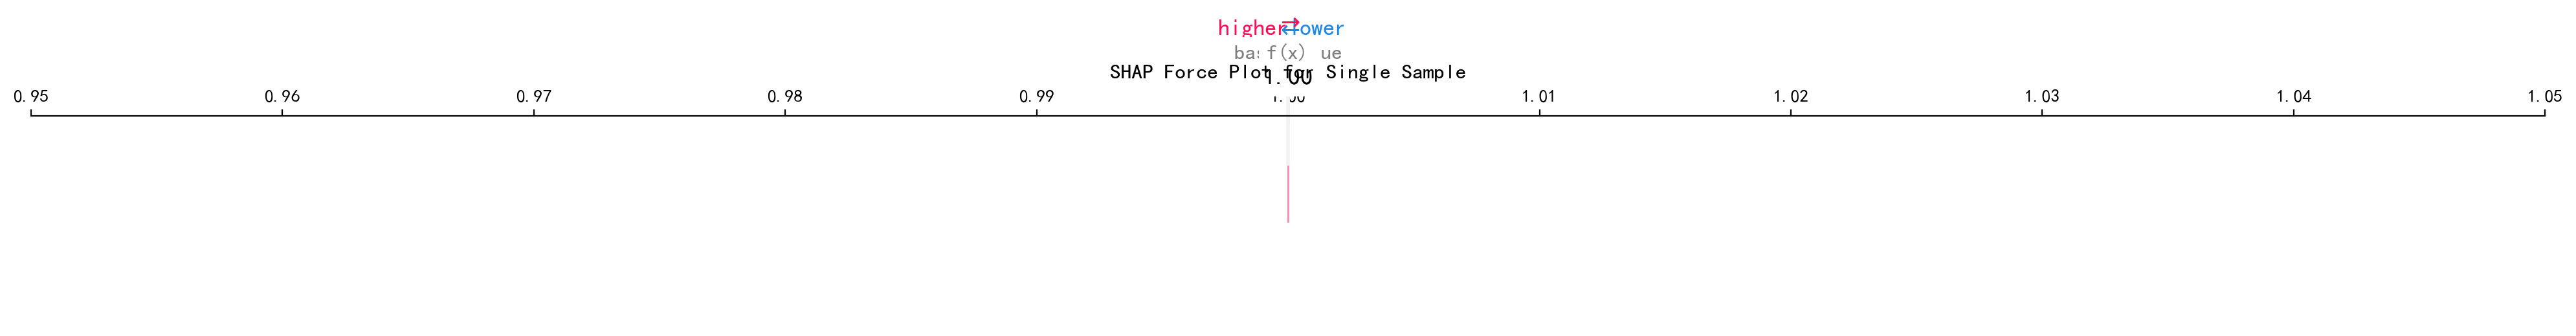

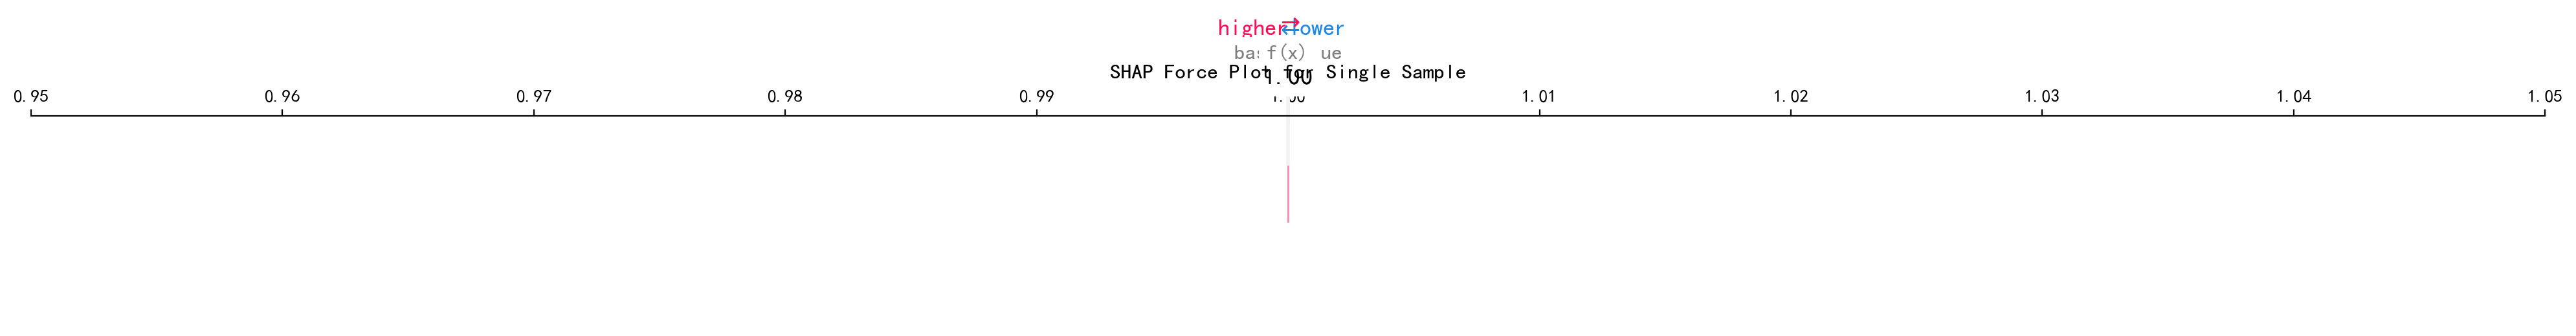

In [29]:
# 用shap库画特征重要性图
import shap
# 假设 rf_model 是已经训练好的随机森林模型
# 初始化 SHAP 解释器
explainer = shap.TreeExplainer(rf_model)
# 计算 SHAP 值
shap_values = explainer.shap_values(x_test)

# --- 4. SHAP 单个样本解释图 (Force Plot) --- 
print("--- 4. SHAP 单个样本解释图 ---") 
shap.force_plot(explainer.expected_value[0], 
                shap_values[0], 
                x_test.iloc[0,:], 
                matplotlib=True, 
                show=False, 
                text_rotation=30) 
plt.title("SHAP Force Plot for Single Sample") 
plt.tight_layout() 
plt.show()

--- 5. SHAP 决策图 ---


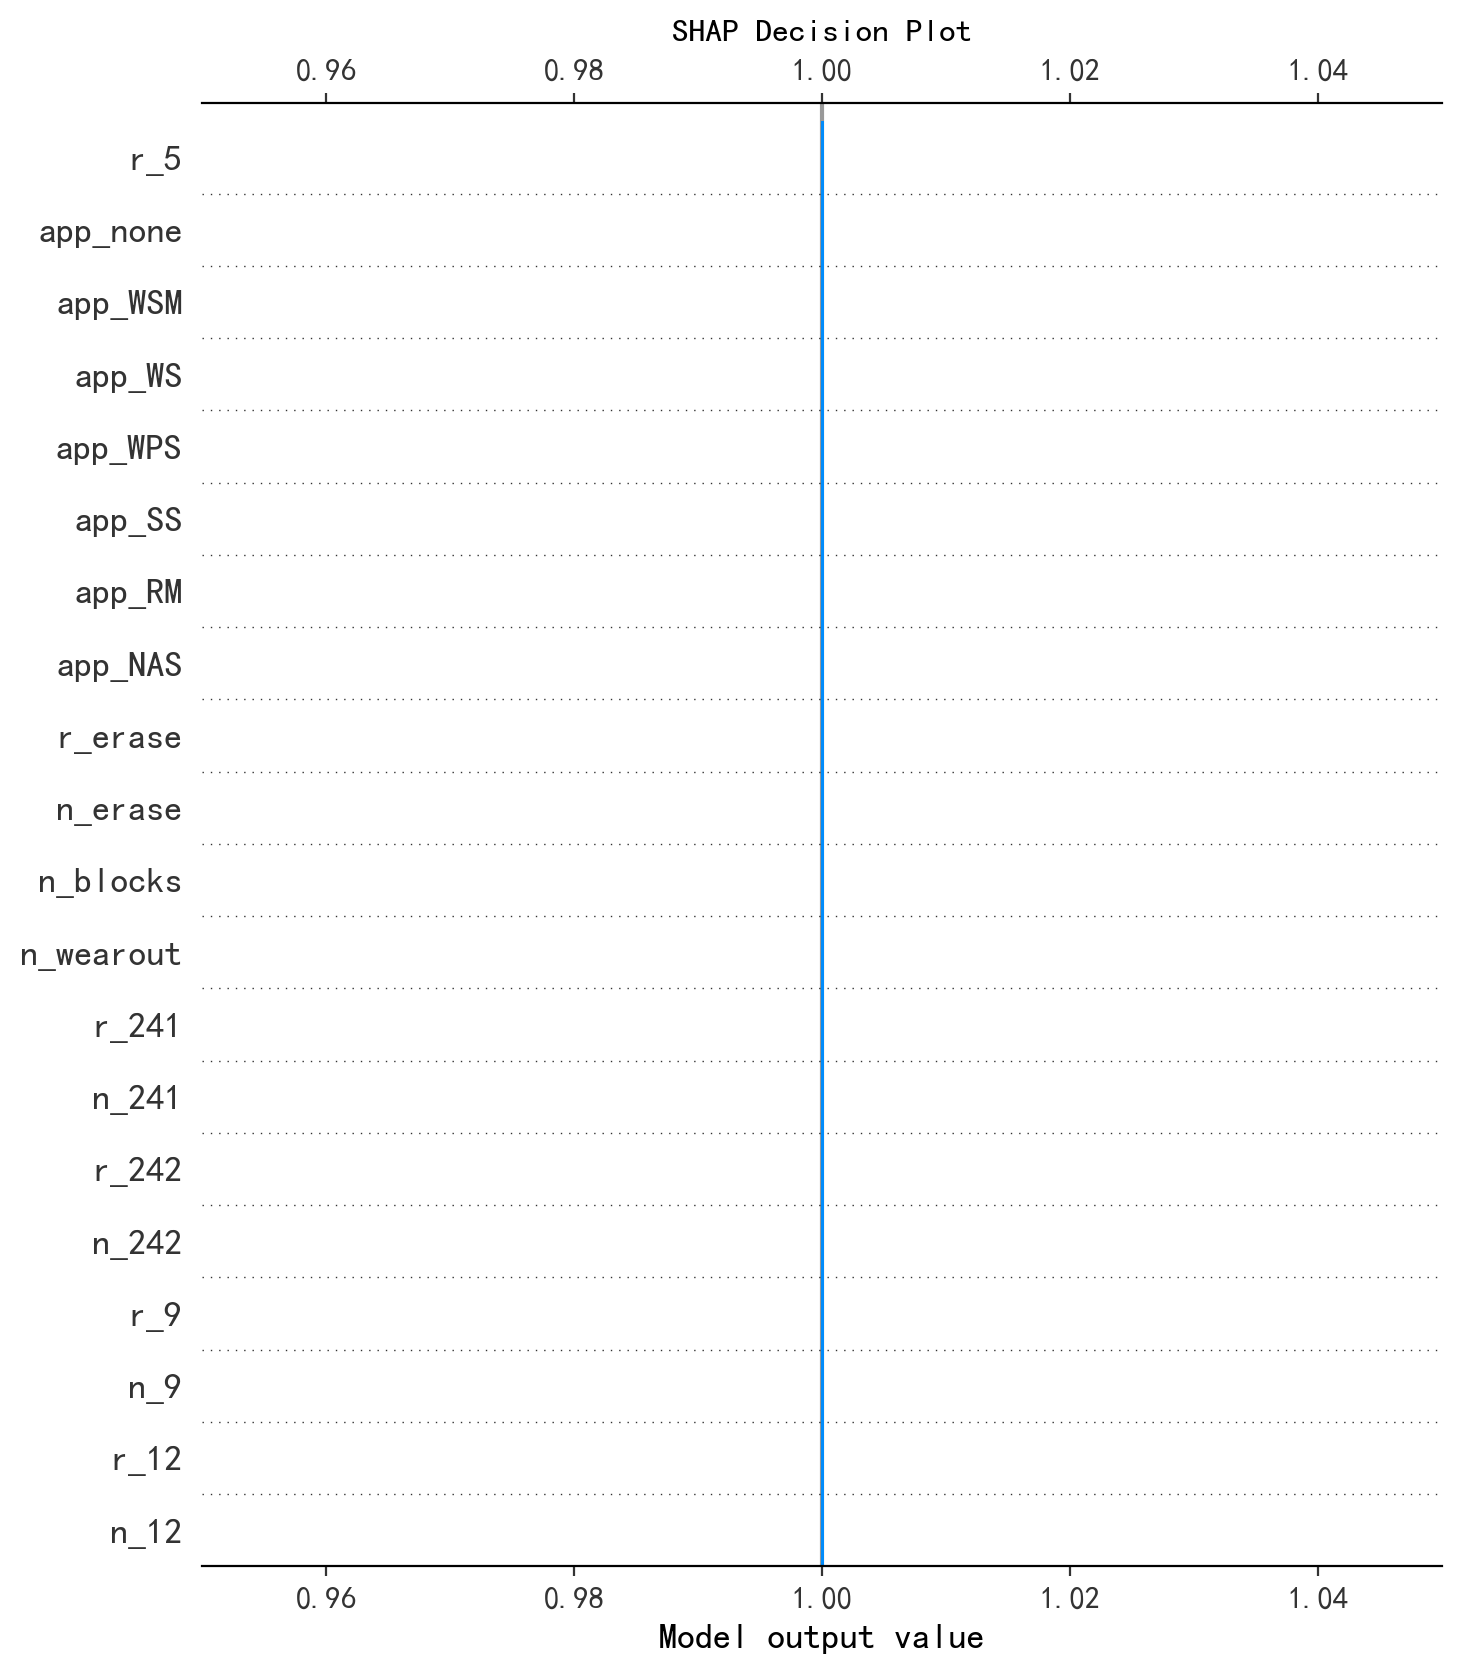

In [30]:
# --- 5. SHAP 决策图 (Decision Plot) ---
print("--- 5. SHAP 决策图 ---")
shap.decision_plot(explainer.expected_value[0], 
                  shap_values[:30], 
                  x_test.iloc[:30,:], 
                  feature_order='importance',
                  show=False)
plt.title("SHAP Decision Plot")
plt.show()
